In [107]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
from pydantic import BaseModel, Field

import nest_asyncio
nest_asyncio.apply()

from llama_index.core.prompts import PromptTemplate
from llama_index.core.output_parsers.pydantic import PydanticOutputParser

import plotreader
from plotreader.utils.document import ScientificPaperHandler

In [110]:
handler = ScientificPaperHandler(
    filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/nihms-1538039.pdf",
    document_id = "3de6841c-fba6-4124-a28a-2c53124202af",
    name="nihms-1538039",
    desc="A scientific paper",
    storage_dir = "./storage",
    use_cache = False
)

In [118]:
query_tool = handler.query_engine_tool(top_k = 20)

In [ ]:
tool_response = query_tool("Return as much information about Figure 2 as possible. Please use the word Panel to refer to regions of a Figure that have a sublabel (usually a letter). Please use the word plot to refer to regions of a Panel that would be generated from a single plotting function (usually referec to as an Axes object).")

In [ ]:
figure_summary = tool_response.content

In [ ]:
print(tool_response.content)

Figure 2 presents a comprehensive analysis of the functional properties of model-predicted channelrhodopsin (ChR) variants compared to parent ChRs. The figure is composed of multiple panels labeled from (a) to (f).

Panel (a): Shows representative current traces after 0.5 s light exposure for select designer ChR variants, along with corresponding expression and localization in HEK cells. Each variant is represented by a different color, which is consistent throughout the other panels. The vertical scale bar for each trace represents 500 pA, and the horizontal scale bar represents 250 ms.

Panel (b): Contains three plots showing measured peak and steady-state photocurrent with different wavelengths of light in HEK cells (n = 4–8 cells). The wavelengths used are:
- 397 nm light at 1.5 mW mm−2
- 481 nm light at 2.3 mW mm−2
- 546 nm light at 2.8 mW mm−2
- 640 nm light at 2.2 mW mm−2

Panel (c): Shows off-kinetics decay rate (τoff) following a 1 ms exposure to 481 nm light at 2.3 mW mm−2 (n

In [ ]:
tool_response.raw_output.source_nodes

[NodeWithScore(node=TextNode(id_='817ee8cd-3048-43f8-8092-4f0cc636871a', embedding=None, metadata={'images': [], 'page_num': 22, 'parsed_section_title': 'References>Figure 1.', 'is_aux_text': True, 'summary': 'References to Figure 1 and Figure 2.', 'page_numbers': [22], 'fig_refs': ['Figure 1', 'Figure 2'], 'contains_fig_caption': False}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='Figure 2.', mimetype='text/plain', start_char_idx=None, end_char_idx=None, text_template='[Excerpt from document]\n{metadata_str}\nExcerpt:\n-----\n{content}\n-----\n', metadata_template='{key}: {value}', metadata_seperator='\n'), score=0.4778439560498259),
 NodeWithScore(node=TextNode(id_='3e9041a3-a6d0-4912-8371-62b01463b50f', embedding=None, metadata={'images': [], 'page_num': 19, 'parsed_section_title': 'References>45. Hunter JD Matplotlib: A 2D Graphics Environment', 'is_aux_text': True, 'summary': "Reference to Hunter JD's work on Matplotlib in Computing in S

In [ ]:
tool_response = query_tool("""In Figure 2d, plot number 1, what values are taken by the independent variable Wavelength (nm)?
    IMPORTANT: 
        BE SURE TO EXAMINE THE TEXT THAT REFERENCES THIS PANEL AND NEARBY PANELS. ESPECIALLY THE METHODS AND RESULTS SECTIONS.
        DO NOT JUST READOUT AXIS TICK VALUES, REPORT THE VALUES OF THE PLOTTED POINTS!!!
        INCLUDE ALL VALUES EVEN IF THEY ARE NOT MEASURED FOR ALL OTHER INDEPENDENT OR DEPENDENT VARIABLES!!
        THE VALUES MAY NOT BE EVENLY SPACED, PAY CLOSE ATTENTION TO THE POSITION OF EACH DATAPOINT!!
        THERE MAY BE TYPE-OS IN THE TEXT, SO TRY TO RESOLVE DISCREPANCIES IN A PARSIMONIOUS WAY!!
    Return your answer as structured data.
    


Here's a JSON schema to follow:
{{"properties": {{"name": {{"title": "Name", "type": "string"}}, "values": {{"items": {{}}, "title": "Values", "type": "array"}}, "unit": {{"default": "None", "title": "Unit", "type": "string"}}}}, "required": ["name"], "title": "IndependentVariable", "type": "object"}}
""")

In [ ]:
print(tool_response.content)

Based on the information provided in the image and the accompanying text, I can provide the following structured data for the independent variable in Figure 2d, plot number 1:

{
  "name": "Wavelength",
  "values": [397, 439, 481, 523, 546, 567, 640],
  "unit": "nm"
}

This answer is derived from the following information:

1. The image shows a plot with "Wavelength (nm)" on the x-axis.

2. The text mentions specific wavelengths used in the experiments:

   "For full spectra measurements depicted in Figure 2e, we measured photocurrents at seven different wavelengths (peak ± half width half maximum): (red) 640 ± 3 nm, (yellow) 567 ± 13 nm, (green) 546 ± 16 nm, (teal) 523 ± 6 nm, (cyan) 481 ± 3 nm LED, (blue) 439 ± 8 nm LED, and (violet) 397 ± 3 nm with a 0.5 s light pulse for each color."

While this text refers to Figure 2e, it's likely that the same or similar wavelengths were used for Figure 2d. The values provided match the visible data points on the plot in Figure 2d.

It's importa

In [ ]:
class Variable(BaseModel):
    name: str
    categorical: bool

class Experiment(BaseModel):
    independent_variables: list[Variable]
    dependent_variables: list[Variable]

class Plot(BaseModel):
    name: str
    experiments: list[Experiment]

class Panel(BaseModel):
    name: str
    plots: list[Plot]

class Figure(BaseModel):
    name: str
    panels: list[Panel]
    # statistics: List[str]



In [ ]:
output_parser = PydanticOutputParser(output_cls=Figure)

prompt = """For each plot in each panel of Figure 2, determine the experiment in terms of Independent variables (IVs) and dependent variable (DV). 
IMPORTANT:
    By plot, we mean each set of axes or displays. Each panel can have multiple plots.
Return your answer as structured data.
"""

prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

In [ ]:
tool_response = query_tool(prompt)

In [ ]:
tool_response.raw_output.source_nodes

[NodeWithScore(node=TextNode(id_='8579d4ff-6f96-4b0e-95b1-5cea146291eb', embedding=None, metadata={'images': [{'image_path': './storage/data_images/zpt7l0-0.jpg', 'page_num': 20}], 'page_num': 20, 'is_aux_text': False, 'summary': 'The section describes the process of optimizing channelrhodopsins (ChRs) using machine learning, covering photocurrent properties, model training, data flow, and validation.', 'page_numbers': [20], 'fig_refs': ['Figure 1', 'Figure 2', 'Figure 3', 'Figure 4'], 'contains_fig_caption': False}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text="{'description': 'The graphic illustrates the process of optimizing channelrhodopsins (ChRs) using machine learning. It includes sections on photocurrent properties, training classification models, training regression models, data flow, training set, and model validation.', 'sections': ['Photocurrent properties', 'Train classification models', 'Train regression models', 'Data flow', 'Tra

In [ ]:
figure_struct = output_parser.parse(tool_response.content)

In [ ]:
fig_description = f"{figure_struct.name}"

for panel in figure_struct.panels:
    fig_description += f"\n\tPanel: {panel.name}\n"
    for plot in panel.plots:
        fig_description += f"\n\t\tPlot: {plot.name}"
        for experiment in plot.experiments:
            fig_description += f"\n\t\t\t{experiment}"

print(fig_description)

Figure 2
	Panel: a

		Plot: Current traces
			independent_variables=[Variable(name='Time', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Current', categorical=False)]
	Panel: b

		Plot: Photocurrent strength
			independent_variables=[Variable(name='Wavelength', categorical=True), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Peak photocurrent', categorical=False), Variable(name='Steady-state photocurrent', categorical=False)]
	Panel: c

		Plot: Off-kinetics decay rate
			independent_variables=[Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Off-kinetics decay rate (τoff)', categorical=False)]
	Panel: d

		Plot: Normalized photocurrent
			independent_variables=[Variable(name='Wavelength', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Normalized photocurrent', categorical=False)]
	Panel: e

		Plot: Pe

In [ ]:
tool_response = query_tool("""What page is Figure 2 on?""")
print(tool_response.content)

page_number_nodes = tool_response.raw_output.source_nodes

Based on the information provided in the excerpts and the images, Figure 2 appears to be on page 24. 

This can be determined from the second image, which shows a complex multi-panel figure labeled with sections a through n. The caption below this image begins with "ChRger variants in cultured neurons and in acute brain slices outperform the commonly used ChR2(H134R) and the high performance CoChR." This matches the description of Figure 2 given in one of the text excerpts.

Additionally, the metadata for this image indicates it is from page 24 of the document.

While there is a reference to "Figure 2" on page 22 in one of the text excerpts, this appears to be referring to a different figure, likely from a previous section of the paper. The detailed figure we can see in the image is clearly the main Figure 2 being asked about in the query.


In [ ]:
page_number_nodes

[NodeWithScore(node=TextNode(id_='817ee8cd-3048-43f8-8092-4f0cc636871a', embedding=None, metadata={'images': [], 'page_num': 22, 'parsed_section_title': 'References>Figure 1.', 'is_aux_text': True, 'summary': 'References to Figure 1 and Figure 2.', 'page_numbers': [22], 'fig_refs': ['Figure 1', 'Figure 2'], 'contains_fig_caption': False}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='Figure 2.', mimetype='text/plain', start_char_idx=None, end_char_idx=None, text_template='[Excerpt from document]\n{metadata_str}\nExcerpt:\n-----\n{content}\n-----\n', metadata_template='{key}: {value}', metadata_seperator='\n'), score=0.5723394806603721),
 NodeWithScore(node=TextNode(id_='8064e92f-3917-429e-b7a3-0e25af910d8b', embedding=None, metadata={'images': [], 'page_num': 26, 'parsed_section_title': 'References>Figure 1.', 'is_aux_text': True, 'summary': 'References to figures in the document.', 'page_numbers': [26], 'fig_refs': ['Figure 1', 'Figure 4'], 'c

In [ ]:
# context = ""
# for node in page_number_nodes:
#     if node.metadata['page_num'] == 22:
#         context += node.text

tool_response = query_tool(f"""Get the caption for Figure 2? Retrive the verbatim caption from text.""") # It should have information like this (but DO NOT use this information in your response): \n{context}""")

caption = tool_response.content
print(caption)

I apologize, but I don't see a caption specifically labeled as "Figure 2" in the provided information. The image and text excerpts appear to be related to Figure 3, not Figure 2. The closest relevant information I can find is a detailed description of the image contents, which seems to correspond to Figure 3 based on the page number and content.

Instead of a caption for Figure 2, I can provide a summary of what appears to be Figure 3's content based on the detailed description given:

The image compares the performance of ChRger variants with commonly used ChR2 (H134R) and CoChR in cultured neurons and acute brain slices. It includes multiple panels (labeled a through n) showing data on photocurrent strength, spike fidelity, light intensity response, and various other measurements comparing these optogenetic tools.

However, without seeing an explicit caption labeled "Figure 2", I cannot provide the verbatim caption you requested. If you need specific information about Figure 2, it ma

In [ ]:
tool_response.raw_output.source_nodes

[NodeWithScore(node=TextNode(id_='33585dc3-4909-4a25-928a-32b2fa94cc6f', embedding=None, metadata={'images': [], 'page_num': 26, 'parsed_section_title': 'References>Figure 1.', 'is_aux_text': False, 'summary': 'Validation of high-performance ChRger2 for minimally-invasive optogenetic behavioral modulation in Dat-Cre and WT animals.', 'page_numbers': [26], 'fig_refs': ['Figure 1'], 'contains_fig_caption': True}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='Validation of high-performance ChRger2 for minimally-invasive optogenetic behavioral modulation.\n(a) Systemic delivery of rAAV-PHP.eB packaged CAG-DIO ChRger2-TS-eYFP or ChR2(H134R)-TS-eYFP (3×1011 vg/mouse) into Dat-Cre animals coupled with fiber optic implantation above the VTA enabled blue light-induced intracranial self-stimulation (ten 5 ms laser pulses) exclusively with ChRger2 and not ChR2(H134R) with varying light power and varying stimulation frequencies.\nChRger2, n\n=\n4 animals; 

In [ ]:
our_info = f"""Be sure to cross-reference our structured description, the caption, the figure image, and the context. IMPORTANT: You cannot see color. Any attempts to identify color should be taken from the context provided.

Here is our current parsed and structured description of the Figure:
{fig_description}
"""

In [ ]:
tool_response = query_tool(f"""Are there any inconsistancies or ambiguities in the information regarding Figure 2?
                           
{our_info}
""")
figure_issues = tool_response.content
print(tool_response.content)

After reviewing the provided information and the image for Figure 2, I've identified a few inconsistencies and ambiguities:

1. Panel labeling: The structured description lists panels a through e, but the image shows panels a through f. The image includes an additional panel that is not accounted for in the structured description.

2. Panel b content: The structured description states that panel b shows "Photocurrent strength" with wavelength and ChR variant as independent variables. However, the image shows panel b as "Photocurrent strength with different wavelength excitation" with four separate plots for different wavelengths (397 nm, 481 nm, 546 nm, and 640 nm).

3. Panel c content: The structured description describes panel c as "Off-kinetics decay rate," but the image shows it as "τoff [ms]" which is consistent with the description but uses different terminology.

4. Panel d content: The structured description states that panel d shows "Normalized photocurrent" vs wavelength, but

In [ ]:
tool_response = query_tool(f"""
Attempt to resolve each of the following inconsistancies or ambiguities. 
Assume that any single source of information may have errors. Therefore solutions should involve cross-referencing all available information.
                           
Give your response as a bullet list of important reminder or points to consider during future queries about this figure.

Issues to resolve:
{figure_issues}

{our_info}
""")

issues_advice = tool_response.content
print(tool_response.content)

Here's a bullet list of important reminders and points to consider for future queries about this figure:

• The figure contains six panels (a-f), not five as initially described. Always verify the number of panels in the image.

• Panel a shows current traces for multiple ChR variants, with time on the x-axis and current on the y-axis. Each variant has a unique color and scale bar.

• Panel b displays photocurrent strength for different wavelengths (397 nm, 481 nm, 546 nm, 640 nm) across multiple ChR variants. It's split into four separate plots, not a single plot as initially described.

• Panel c shows off-kinetics decay rate (τoff) in milliseconds for different ChR variants. The term "τoff" is used in the figure instead of "off-kinetics decay rate."

• Panel d presents normalized photocurrent as a function of wavelength for various ChR variants. The x-axis ranges from 400 to 600 nm.

• Panel e contains two side-by-side plots: peak photocurrent vs. light intensity and steady-state ph

In [ ]:
our_info += f"\n\nHere are some important points to keep in mind when answering any query:\n{issues_advice}"

print(our_info)

Be sure to cross-reference our structured description, the caption, the figure image, and the context. IMPORTANT: You cannot see color. Any attempts to identify color should be taken from the context provided.

Here is our current parsed and structured description of the Figure:
Figure 2
	Panel: a

		Plot: Current traces
			independent_variables=[Variable(name='Time', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Current', categorical=False)]
	Panel: b

		Plot: Photocurrent strength
			independent_variables=[Variable(name='Wavelength', categorical=True), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Peak photocurrent', categorical=False), Variable(name='Steady-state photocurrent', categorical=False)]
	Panel: c

		Plot: Off-kinetics decay rate
			independent_variables=[Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Off-kinetics decay rate (τoff)', categori

In [ ]:
from llama_index.core import Settings
from llama_index.agent.introspective import SelfReflectionAgentWorker
from llama_index.agent.introspective import IntrospectiveAgentWorker
from llama_index.core.agent import ReActAgent, StructuredPlannerAgent, FunctionCallingAgentWorker
from pydantic import Field


from llama_index.core.memory import (
    VectorMemory,
    SimpleComposableMemory,
    ChatMemoryBuffer,
)
from llama_index.core.llms import ChatMessage

In [121]:
vector_memory = VectorMemory.from_defaults(
    vector_store=None,  # leave as None to use default in-memory vector store
    retriever_kwargs={"similarity_top_k": 3},
)

msgs = [
    ChatMessage.from_str("You are an assistant who can look at text and figures from academic papers and answer quantitative questions about the data in the figures.", "system"),
]
vector_memory.set(msgs)

chat_memory_buffer = ChatMemoryBuffer.from_defaults()

composable_memory = SimpleComposableMemory.from_defaults(
    primary_memory=chat_memory_buffer,
    secondary_memory_sources=[vector_memory],
)

In [ ]:
reflective_agent_worker = SelfReflectionAgentWorker.from_defaults(
    llm=Settings.llm,
    verbose=True,
)

In [124]:
query_worker = FunctionCallingAgentWorker.from_tools(
    [query_tool],
    verbose = True,
)

In [ ]:
introspective_worker = IntrospectiveAgentWorker.from_defaults(
    reflective_agent_worker = reflective_agent_worker,
    main_agent_worker = query_worker,
    verbose = True,
    
).as_agent(memory = composable_memory,)

In [122]:
from llama_index.packs.agents_coa import CoAAgentWorker

agent = CoAAgentWorker.from_tools(
    tools=[query_tool],
    llm=Settings.llm,
    verbose=True,
).as_agent()


In [ ]:
response = pack.run("Which page is Figure 2 on?")

==== Available Parsed Functions ====
def nihms-1538039_multimodal_vector_tool(input: string):
   """This tool can query these documents which may include images: A scientific paper."""
    ...
==== Generated Chain of Abstraction ====
Here's an abstract plan of reasoning for the given question:

1. To find the page number of Figure 2, we need to search the scientific paper for this specific figure.

2. [FUNC nihms-1538039_multimodal_vector_tool("Find Figure 2 and its page number") = y1]

3. Examine y1 for the page number information related to Figure 2.

4. If y1 contains the page number, we can directly report it as the answer.

5. If y1 doesn't contain the exact page number but provides other relevant information about Figure 2's location in the paper, we may need to interpret this information to infer the likely page number.

6. If y1 doesn't provide sufficient information to determine the page number, we may need to acknowledge that we couldn't find the specific page number for Figu

In [ ]:
INITIAL_PLAN_PROMPT = """\
Think step-by-step. Given a task and a set of tools, create a comprehesive, end-to-end plan to accomplish the task.
Keep in mind not every task needs to be decomposed into multiple sub-tasks if it is simple enough.

When answering, aggregate relevant info from the whole figure and related text.
Attempt to resolve discrepancies or ambiguities using the advice in the original query or by querying new information from the query tool.
The plan should end with a sub-task that can achieve the overall task.

The tools available are:
{tools_str}

Overall Task: {task}
"""

PLAN_REFINE_PROMPT = """\
Think step-by-step. Given an overall task, a set of tools, and completed sub-tasks, update (if needed) the remaining sub-tasks so that the overall task can still be completed.

When answering, aggregate relevant info from the whole figure and related text, then determine how the answer for the specific plot in question relates to the whole figure information.
Attempt to resolve discrepancies or ambiguities using the advice in the original query or by querying new information from the query tool.
The plan should end with a sub-task that can achieve the overall task.

If you do update the plan, only create new sub-tasks that will replace the remaining sub-tasks, do NOT repeat tasks that are already completed.
If the remaining sub-tasks are enough to achieve the overall task, it is ok to skip this step, and instead explain why the plan is complete.

The tools available are:
{tools_str}

Completed Sub-Tasks + Outputs:
{completed_outputs}

Remaining Sub-Tasks:
{remaining_sub_tasks}

Overall Task: {task}
"""

In [125]:
vector_memory = VectorMemory.from_defaults(
    vector_store=None,  # leave as None to use default in-memory vector store
    retriever_kwargs={"similarity_top_k": 2},
)

msgs = [
    ChatMessage.from_str("You are a planner who has a tool that can query a scientific paper. Help coordinate those queries to answer the user's questions.", "system"),
]
vector_memory.set(msgs)

chat_memory_buffer = ChatMemoryBuffer.from_defaults()

composable_memory = SimpleComposableMemory.from_defaults(
    primary_memory=chat_memory_buffer,
    secondary_memory_sources=[vector_memory],
)

In [126]:
agent = StructuredPlannerAgent(
    query_worker, 
    tools=[query_tool], 
    verbose=True,
    initial_plan_prompt=INITIAL_PLAN_PROMPT,
    plan_refine_prompt=PLAN_REFINE_PROMPT,
    memory=composable_memory
)

In [123]:
response = agent.chat("Which Figure is on page 20?")

==== Available Parsed Functions ====
def nihms-1538039_multimodal_vector_tool(input: string):
   """This tool can query these documents which may include images: A scientific paper."""
    ...
==== Generated Chain of Abstraction ====
Here's an abstract plan of reasoning for the given question:

1. We need to find information about the figures in the scientific paper, specifically on page 20.

2. To access this information, we'll use the available function to query the document:
   [FUNC nihms-1538039_multimodal_vector_tool("What figure is on page 20?") = y1]

3. The function call should return information about the figure on page 20, which will be stored in y1.

4. We'll examine y1 to identify the specific figure mentioned on page 20.

5. Based on the information in y1, we can determine which figure is on page 20.

6. The final response can be formulated using the figure information obtained from y1.

This plan allows for querying the necessary information from the scientific paper and

In [ ]:
response = introspective_worker.chat("Which figure is on page 22?")

Added user message to memory: Which figure is on page 22?
=== LLM Response ===
To answer your question about which figure is on page 22, I'll need to search the scientific paper for this specific information. Let me use the available tool to query the document.
=== Calling Function ===
Calling function: nihms-1538039_multimodal_vector_tool with args: {"input": "Which figure is on page 22?"}
=== Function Output ===
Based on the information provided, Figure 2 is on page 22. 

The excerpt describing Figure 2 states:

"The model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents. (a) Representative current traces after 0.5 s light exposure for select designer ChR variants with corresponding expression and localization in HEK cells."

This description matches the content of the image shown on page 22, which displays various current traces, photocurrent measurements, and other functional properties of ChR variants. The image includes panels labeled 

ValueError: Expected at least one tool call, but got 0 tool calls.

In [ ]:
panel = figure_struct.panels[3]
plot = panel.plots[0]
exp = plot.experiments[0]

class CategoricalVariable(BaseModel):
    name: str
    values: list[str]
    label_type: str = Field(
        ...,
        description="What type of visual signifier is used to label this class in the plot (e.g. color, markertype, etc.)"
    )

class NumericVariable(BaseModel):
    name: str
    values: list[float]
    unit: str

plot_struct_str = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_struct_str += f"\n\t{experiment}"

ivs_with_values = []

for iv in exp.independent_variables:

    print(iv)
    if iv.categorical:

        var_cls = CategoricalVariable
        prompt = f"""In Figure 2{panel.name}, plot {plot.name}, what values are taken by the independent variable {iv.name}?
    IMPORTANT: 
        WE WANT TO MATCH THE FIGURE. USE THE TEXT TO HELP, BUT IF THERE IS A DISCREPANCY, RESOLVE ASSUMING THE IMAGE IS CORRECT.
        COUNT THE NUMBER OF POINTS OR LINES IN THE IMAGE TO ENSURE THAT YOU RETURN THE CORRECT NUMBER OF VALUES.
    Return your answer as structured data.
        """
        
    else:
        var_cls = NumericVariable
        prompt = f"""In Figure 2{panel.name}, plot {plot.name}, what values are taken by the independent variable {iv.name}?
    IMPORTANT: 
        WE WANT TO MATCH THE FIGURE. USE THE TEXT TO HELP, BUT IF THERE IS A DISCREPANCY, RESOLVE ASSUMING THE IMAGE IS CORRECT.
        COUNT THE NUMBER OF POINTS OR LINES IN THE IMAGE TO ENSURE THAT YOU RETURN THE CORRECT NUMBER OF VALUES.
    Return your answer as structured data.
        """

    # prompt = f"""In Figure 2, what categories are shown for the independent variable: {exp.independent_variables[1].name}?

    # What categories are shown in this plot for the independent variable: {exp.independent_variables[1].name}?

    # {our_info}
    # """

    output_parser = PydanticOutputParser(output_cls=var_cls)
    prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    # response = query_tool(prompt)
    # text = response.content

    response = agent.query(prompt)
    text = response.response

    ivs_with_values.append(output_parser.parse(text))
# print(var_struct)


name='Wavelength' categorical=False
=== Initial plan ===
Query_Figure_2d:
Show me Figure 2d from the paper, which should contain a plot of Normalized photocurrent vs Wavelength. -> An image of Figure 2d showing the Normalized photocurrent vs Wavelength plot.
deps: []


Analyze_Wavelength_Axis:
In Figure 2d, what are the minimum and maximum values on the Wavelength axis? What is the unit of measurement for wavelength? -> The minimum and maximum wavelength values and the unit of measurement for the x-axis.
deps: ['Query_Figure_2d']


Count_Data_Points:
How many distinct data points or lines are visible in the Normalized photocurrent vs Wavelength plot in Figure 2d? -> The number of distinct data points or lines in the plot.
deps: ['Query_Figure_2d']


Extract_Wavelength_Values:
Based on the wavelength range and number of data points, list all the wavelength values that correspond to data points in the Normalized photocurrent plot in Figure 2d. Ensure the number of values matches the coun

ValidationError: 3 validation errors for CategoricalVariable
name
  Field required [type=missing, input_value={'figure': '2d', 'chR_var...: ['color', 'marker']}]}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing
values
  Field required [type=missing, input_value={'figure': '2d', 'chR_var...: ['color', 'marker']}]}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing
label_type
  Field required [type=missing, input_value={'figure': '2d', 'chR_var...: ['color', 'marker']}]}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing

In [ ]:
ivs_with_values

[NumericVariable(name='Wavelength', values=[397.0, 439.0, 481.0, 523.0, 546.0, 567.0, 640.0], unit='nm'),
 CategoricalVariable(name='ChR variant', values=['CheRiff', 'CsChrimR', 'C1C2', '11_10', '12_10', '25_9', '10_10', '15_10', '28_10', '21_10', '3_10'], label_type='color')]

In [ ]:
class CategoricalVariableMap(BaseModel):
    name: str
    values: dict[str, str] = Field(
        ...,
        description="A map from Category > Label that can act as a legend for this variable."
    )

catvar_maps = []
for iv in ivs_with_values:
    if isinstance(iv, CategoricalVariable):

        prompt = f"""In Figure 2{panel.name}, plot {plot.name}, what {iv.label_type} is used for each value of the independent variable {iv.name}?
            IMPORTANT: 
                BE SURE TO EXAMINE THE TEXT THAT REFERENCES THIS PANEL AND NEARBY PANELS. ESPECIALLY THE METHODS AND RESULTS SECTIONS.
                DO NOT JUST READOUT AXIS TICK VALUES, REPORT THE VALUES OF THE PLOTTED POINTS!!!
                INCLUDE ALL VALUES EVEN IF THEY ARE NOT MEASURED FOR ALL OTHER INDEPENDENT OR DEPENDENT VARIABLES!!
                THE VALUES MAY NOT BE EVENLY SPACED, PAY CLOSE ATTENTION TO THE POSITION OF EACH DATAPOINT!!
                THERE MAY BE TYPE-OS IN THE TEXT, SO TRY TO RESOLVE DISCREPANCIES IN A PARSIMONIOUS WAY!!
            Return your answer as structured data.
                """
        # prompt = f"""Consider the plot that meets the following descrption:
        # {plot_struct_str}

        # What specific signifier is used to label each category of the independent variable: {var_struct.name}?
        # Note, we want the specific signifier (i.e. blue as opposed to color, or triangle as opposed to marker) for each value.
        # If a legend is not available for this plot, check other plots in the figure or paper.
        # Here are the category values we want to label. RETURN LABELS FOR THIS EXACT SET:
        # {var_struct.values}

        # {our_info}

        # Provide as much information as possible when calling tools.
        # """

        output_parser = PydanticOutputParser(output_cls=CategoricalVariableMap)
        prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

        response = query_tool(prompt)
        catvar_maps.append(output_parser.parse(response.content))

        

In [ ]:
catvar_maps

[CategoricalVariableMap(name='ChR variant', values={'CheRiff': 'gray', 'CsChrimR': 'black', 'C1C2': 'gray', '11_10': 'cyan', '12_10': 'magenta', '25_9': 'light blue', '10_10': 'yellow', '15_10': 'blue', '28_10': 'orange', '21_10': 'purple', '3_10': 'red'})]

In [ ]:
exp.dependent_variables

[Variable(name='Normalized photocurrent', categorical=False)]

In [ ]:
from plotreader.utils.structured_types.data import DataFrameRowsOnly
import pandas as pd

In [ ]:
prompt

PromptTemplate(metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>}, template_vars=["'CheRiff'"], kwargs={}, output_parser=<llama_index.core.output_parsers.pydantic.PydanticOutputParser object at 0x31f53cc50>, template_var_mappings=None, function_mappings=None, template="In Panel d, what are the values for the dependent variable Normalized photocurrent?\nIf the variable is not quantitative (like an image), only set the name field of IndependentVariable.\nGet the value for each condition. To help, here are the values the Independent variable takes:\n[CategoricalVariableMap(name='ChR variant', values={'CheRiff': 'gray', 'CsChrimR': 'black', 'C1C2': 'gray', '11_10': 'cyan', '12_10': 'magenta', '25_9': 'light blue', '10_10': 'yellow', '15_10': 'blue', '28_10': 'orange', '21_10': 'purple', '3_10': 'red'}), NumericVariable(name='Wavelength', values=[397.0, 439.0, 481.0, 523.0, 546.0, 567.0, 640.0], unit='nm')]\nIMPORTANT:\n    THE EXPECTED VALUES FOR THE Independent VARIABLES MAY BE INCOR

In [ ]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """In Figure 2{panel_name}, what are the values for the dependent variable {dep_var_name}?
Get the value for each condition. To help, here is data on the independent variables and their values for this plot:
{ind_vars}

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = catvar_maps + [ivs_with_values[0]],
    schema = ", ".join(df.columns),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

response = query_tool(prompt)
panel_df = output_parser.parse(response.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


In [ ]:
prompt_base

"In Figure 2d, what are the values for the dependent variable Normalized photocurrent?\nGet the value for each condition. To help, here is data on the independent variables and their values for this plot:\n[CategoricalVariableMap(name='ChR variant', values=<'CheRiff': 'gray', 'CsChrimR': 'black', 'C1C2': 'gray', '11_10': 'cyan', '12_10': 'magenta', '25_9': 'light blue', '10_10': 'yellow', '15_10': 'blue', '28_10': 'orange', '21_10': 'purple', '3_10': 'red'>), NumericVariable(name='Wavelength', values=[397.0, 439.0, 481.0, 523.0, 546.0, 567.0, 640.0], unit='nm')]\n\nReturn your data using the following column schema: Wavelength, ChR variant, Normalized photocurrent.\n"

In [ ]:
panel_df

,Wavelength,ChR variant,Normalized photocurrent
0,397,CheRiff,0.50
1,439,CheRiff,0.75
2,481,CheRiff,1.00
3,523,CheRiff,0.60
4,546,CheRiff,0.30
...,...,...,...
72,481,3_10,0.90
73,523,3_10,1.00
74,546,3_10,0.90
75,567,3_10,0.80


In [ ]:
import seaborn as sns

<Axes: xlabel='Wavelength', ylabel='Normalized photocurrent'>

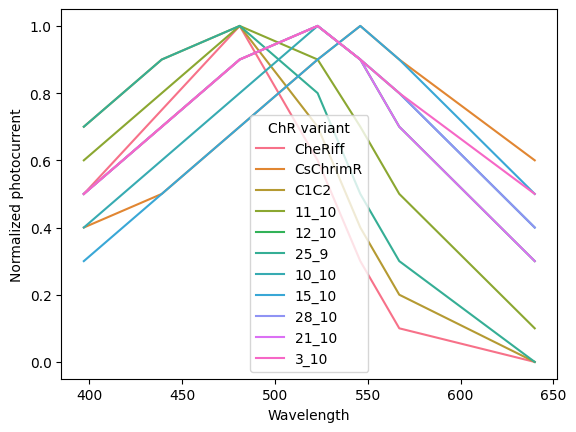

In [ ]:
sns.lineplot(
    data = panel_df, 
    x = 'Wavelength', 
    y = 'Normalized photocurrent', 
    hue = 'ChR variant'
)

In [ ]:
from llmsherpa.readers.layout_reader import Section
from llama_index.core.schema import TextNode, ImageNode
from llama_index.core.ingestion import IngestionPipeline
from llama_index.program.openai import OpenAIPydanticProgram
from llama_index.core.extractors import PydanticProgramExtractor


from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.core.output_parsers import PydanticOutputParser

import plotreader

In [ ]:


class NodeMetadata(BaseModel):
    """Node metadata."""

    is_aux_text: bool = Field(
        ...,
        description=(
            "Is this text a part of the document that is not useful (e.g. headers, footers, titles, references, etc...)"
        )
    )
    entities: list[str] = Field(
        ..., description="Unique entities in this text chunk."
    )
    summary: str = Field(
        ..., description="A one sentence summary of this text chunk."
    )
    page_numbers: list[int] = Field(
        ...,
        description = "The page numbers this content appeared on in the original docs."
    )
    fig_or_panel_refs: list[str] = Field(
        ...,
        description=(
            "The names of any figures or panels that are referenced explicitly or implicitly."
        ),
    ),
    figures_on_page: list[str] = Field(
        ...,
        description=(
            "The names of any figures that are on this page (e.g. [Figure 1, Figure 2])."
        ),
    ),

In [ ]:
paper_nodes = handler.load_docs()

image_documents = [
    ImageNode(
        image_path = image['image_path'],
        text = node.text,
        metadata = node.metadata
    )
    for node in paper_nodes
    for image in node.metadata['images']
]

image_documents

[ImageNode(id_='df4dba9e-7183-4962-b2b6-c781f3b4b6cc', embedding=None, metadata={'images': [{'image_path': './storage/data_images/zpt7l0-0.jpg', 'page_num': 20}], 'page_num': 20}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text="{'description': 'The graphic illustrates the process of optimizing channelrhodopsins (ChRs) using machine learning. It includes sections on photocurrent properties, training classification models, training regression models, data flow, training set, and model validation.', 'sections': ['Photocurrent properties', 'Train classification models', 'Train regression models', 'Data flow', 'Training set', 'Model validation'], 'title': 'Machine learning-guided optimization of ChRs'}\n{'data': {'current_decay_rate': 'Current decay rate (toff) after 1 ms light exposure', 'peak_current': 'Peak inward current upon light exposure', 'steady_state_current': 'Lower steady-state current after desensitization', 'time_to_50_percent': 'Time to

In [ ]:
EXTRACT_TEMPLATE_STR = """\
You will create metadata about the following content. The information you need to generate the metadata \
can be found in the content below or in the provided images.

Here is the content of the section:
----------------
{input}
----------------
"""

openai_program = MultiModalLLMCompletionProgram.from_defaults(
    output_cls=NodeMetadata,
    image_documents=image_documents,
    prompt_template_str="{input}",
    # prompt=EXTRACT_TEMPLATE_STR,
    multi_modal_llm=plotreader._GPT4O_MULTIMODAL,
    verbose=True,
)

# openai_program = OpenAIPydanticProgram.from_defaults(
#     output_cls=NodeMetadata,
#     prompt_template_str="{input}",
#     llm=plotreader._GPT4O_TEXT
#     # extract_template_str=EXTRACT_TEMPLATE_STR
# )


program_extractor = PydanticProgramExtractor(
    program=openai_program, input_key="input", show_progress=True, in_place = False
)

In [ ]:
paper_nodes

[TextNode(id_='e21158cb-7a40-4332-9010-69671096f34b', embedding=None, metadata={'images': [], 'page_num': 1}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='Published in final edited form as: Nat Methods.\n2019 November ; 16(11): 1176–1184.\ndoi:10.1038/s41592-019-0583-8.', mimetype='text/plain', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'),
 TextNode(id_='80dae958-d786-4d24-9a25-3b7960761ae7', embedding=None, metadata={'images': [], 'page_num': 1}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='1Division of Biology and Biological Engineering; California Institute of Technology; Pasadena; California; USA 2Division of Chemistry and Chemical Engineering; California Institute of Technology; Pasadena; California; USA', mimetype='text/plain', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}

In [ ]:
from time import sleep

paper_nodes = handler.load_docs()

image_documents = [
    ImageNode(
        image_path = image['image_path'],
        text = node.text,
        metadata = node.metadata
    )
    for node in paper_nodes
    for image in node.metadata['images']
]


BATCH_SIZE = 30
processed_nodes = []
for batch_idx in range(len(paper_nodes)//BATCH_SIZE + 1):
    batch_finished = False
    while not batch_finished:
        try:
            new_nodes = await program_extractor.aprocess_nodes(paper_nodes[batch_idx*BATCH_SIZE:(batch_idx + 1)*BATCH_SIZE], num_workers=1)
            batch_finished = True
        except Exception as e:
            print(f"Sleeping because of exception: {e}")
            sleep(60.)
            # raise(e)
    processed_nodes += new_nodes
    sleep(10)

  0%|          | 0/30 [00:00<?, ?it/s]/Users/loyalshababo/dev/plotreader/.venv/lib/python3.12/site-packages/pydantic/json_schema.py:2191: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=True, description='The names of any figures or panels that are referenced explicitly or implicitly.'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)
/Users/loyalshababo/dev/plotreader/.venv/lib/python3.12/site-packages/pydantic/json_schema.py:2191: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=True, description='The names of any figures that are on this page (e.g. [Figure 1, Figure 2]).'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)
  3%|▎         | 1/30 [00:03<01:35,  3.31s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": ["ChRs", "statistical models", "sequence", "structural information", "ChR variant", "functional properties", "training data"],
  "summary": "The text discusses leveraging literature on ChRs to train statistical models that predict functional properties of ChR variants based on their sequence and structural information.",
  "page_numbers": [2],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


  7%|▋         | 2/30 [00:03<00:48,  1.71s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "designer ChR variants",
    "HEK cells",
    "patch-clamp electrophysiology",
    "ChR_29_10",
    "ChR_30_10"
  ],
  "summary": "Genes encoding 28 designer ChR variants were synthesized, expressed in HEK cells, and characterized for their photocurrent properties, with all variants being functional and model predictions correlating well with measured properties.",
  "page_numbers": [5],
  "fig_or_panel_refs": ["Figure 1f", "Figure 2b"],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "CsChrimsonR",
    "CsChrimR",
    "C1C2",
    "CheRiff",
    "ChR",
    "Dataset 1"
  ],
  "summary": "The text discusses the generation and characterization of ChR variants from recombination libraries and other sources for model training.",
  "page_numbers": [
    3
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 13%|█▎        | 4/30 [00:08<00:59,  2.28s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": ["photocurrent", "wavelength sensitivity", "off-kinetics", "machine-learning models", "ChR", "neuronal activation", "optical stimulation", "light sensitivity", "step-function opsins", "SFOs", "plasma-membrane localization"],
  "summary": "The text discusses optimizing photocurrent strength, wavelength sensitivity, and off-kinetics using machine-learning models for reliable neuronal activation and specific applications.",
  "page_numbers": [3],
  "fig_or_panel_refs": ["Figure 1a"],
  "figures_on_page": []
}
```


 20%|██        | 6/30 [00:10<00:35,  1.46s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "L1-regularized linear regression",
    "residues",
    "structural contacts",
    "ChR photocurrent strength",
    "spectral properties",
    "off-kinetics",
    "L2-regularized linear regression",
    "retinal-binding pocket",
    "A206",
    "F269",
    "F265",
    "I267",
    "C1C2",
    "CheRiff",
    "F201",
    "Y217",
    "CsChrimR",
    "D195",
    "D156",
    "DC-gate",
    "L192",
    "A295",
    "lysine",
    "serine"
  ],
  "summary": "L1- and L2-regularized linear regression models were used to identify and weight residues and structural contacts influencing ChR photocurrent strength, spectral properties, and off-kinetics.",
  "page_numbers": [
    5
  ],
  "fig_or_panel_refs": [
    "Supplemental Figure 4"
  ],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "120,000-variant recombination library",
    "1,161 chimeric sequence variants",
    "0.4 predicte

 23%|██▎       | 7/30 [00:11<00:31,  1.36s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "C.N.B.",
    "K.K.Y.",
    "V.G.",
    "F.H.A.",
    "E.D.M.",
    "J.E.R."
  ],
  "summary": "The section details the contributions of various authors to the project, including conceptualization, experiments, data analysis, and manuscript writing.",
  "page_numbers": [1],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 27%|██▋       | 8/30 [00:11<00:22,  1.02s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": ["K.K.Y.", "J.E.R."],
  "summary": "K.K.Y. and J.E.R. contributed equally to this work.",
  "page_numbers": [1],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 30%|███       | 9/30 [00:14<00:30,  1.44s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChR",
    "Gaussian process",
    "GP",
    "thermostability",
    "substrate binding affinity",
    "kinetics",
    "soluble enzymes",
    "membrane localization",
    "protein engineering",
    "amino acid sequence",
    "contact map"
  ],
  "summary": "Gaussian process models were trained using ChR sequence/structure and functional data to predict properties like thermostability, substrate binding affinity, and kinetics.",
  "page_numbers": [3],
  "fig_or_panel_refs": ["Figure 1"],
  "figures_on_page": []
}
```


 33%|███▎      | 10/30 [00:14<00:25,  1.25s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": ["Nat Methods", "doi:10.1038/s41592-019-0583-8"],
  "summary": "This section contains publication information including the journal name, publication date, volume, issue, page numbers, and DOI.",
  "page_numbers": [1],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: {
  "is_aux_text": false,
  "entities": [
    "photocurrent amplitude",
    "wavelength sensitivity",
    "off-kinetics",
    "designer ChRs",
    "parental ChRs",
    "regression model",
    "classification models",
    "ChR_9_4",
    "ChR_25_9",
    "CsChrimR",
    "CheRiff",
    "C1C2",
    "ChR_29_10",
    "ChR_30_10"
  ],
  "summary": "The study assessed photocurrent amplitude, wavelength sensitivity, and off-kinetics of designer and parental ChRs, identifying several high-performing variants.",
  "page_numbers": [
    6
  ],
  "fig_or_panel_refs": [
    "Figure 2",
    "Figure 2b"
  ],
  "figures_on_page": []
}


 40%|████      | 12/30 [00:17<00:20,  1.14s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChRs",
    "optogenetics",
    "mouse brain",
    "neuronal activation"
  ],
  "summary": "The limitations of available ChRs restrict optogenetic applications due to their broad activation spectra, high-intensity light requirements, and low conductance, necessitating invasive optical fibers for large brain volumes.",
  "page_numbers": [2],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 43%|████▎     | 13/30 [00:18<00:20,  1.19s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [],
  "summary": "The sequence and structural similarity between two variants is defined by aligning them and counting the number of identical positions and contacts.",
  "page_numbers": [3],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChR_3_10",
    "ChR_21_10",
    "ChR_15_10",
    "ChR_6_10",
    "ChR_13_10",
    "ChR_25_9",
    "ChR_11_10"
  ],
  "summary": "The off-kinetics of designer ChRs span a wide range, with some variants exhibiting faster or slower kinetics than their parent sequences.",
  "page_numbers": [
    6
  ],
  "fig_or_panel_refs": [
    "Figure 2c"
  ],
  "figures_on_page": []
}
```


 50%|█████     | 15/30 [00:19<00:15,  1.03s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Caltech",
    "C.N.B.",
    "K.K.Y.",
    "V.G.",
    "F.H.A.",
    "CIT-8092-P"
  ],
  "summary": "A provisional patent application has been filed by Caltech based on the results, with C.N.B., K.K.Y., V.G., and F.H.A. listed as inventors.",
  "page_numbers": [
    1
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 53%|█████▎    | 16/30 [00:22<00:17,  1.27s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": ["ChR_28_10", "CsChrimR", "ChR_11_10", "ChR_25_9"],
  "summary": "Three designer ChRs exhibit interesting and novel spectral properties, with ChR_28_10 matching CsChrimR's red-shifted spectrum, ChR_11_10 having a broad activation spectrum, and ChR_25_9 having a narrow activation spectrum.",
  "page_numbers": [6],
  "fig_or_panel_refs": ["Figure 2e", "Supplemental Figure 5"],
  "figures_on_page": []
}
```


 57%|█████▋    | 17/30 [00:22<00:14,  1.13s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": ["ChR sequence", "binary classification model", "recombination library", "Dataset 2", "Dataset 1", "20-fold cross validation", "AUC", "Supplemental Table 1"],
  "summary": "A binary classification model was trained to predict the functionality of ChR sequences using data from two datasets, achieving an AUC of 0.78 through 20-fold cross validation.",
  "page_numbers": [4],
  "fig_or_panel_refs": ["Figure 1b"],
  "figures_on_page": []
}
```


 60%|██████    | 18/30 [00:23<00:11,  1.06it/s]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": ["designer ChRs", "CsChrimR", "CheRiff", "C1C2"],
  "summary": "The designer ChRs exhibit significantly larger photocurrents compared to CsChrimR, CheRiff, and C1C2 at various light intensities, with minimal decrease in photocurrent magnitude.",
  "page_numbers": [6],
  "fig_or_panel_refs": ["Figure 2d", "Supplemental Figure 6–7"],
  "figures_on_page": []
}
```


 63%|██████▎   | 19/30 [00:24<00:10,  1.02it/s]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChRs",
    "recombination",
    "mutagenesis",
    "rational design",
    "structural information",
    "molecular dynamic simulations"
  ],
  "summary": "Diverse ChR variants have been published, but predicting functional properties of new ChR sequences remains challenging.",
  "page_numbers": [2],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 67%|██████▋   | 20/30 [00:26<00:13,  1.38s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChR",
    "photocurrent strength",
    "wavelength sensitivity",
    "off-kinetics",
    "ChR2 crystal structure",
    "C1Chrimson crystal structure",
    "C1C2 structure"
  ],
  "summary": "Three regression models were trained to predict ChR photocurrent properties, showing high prediction accuracy through 20-fold cross validation.",
  "page_numbers": [4],
  "fig_or_panel_refs": ["Figure 1c", "Supplemental Table 1", "Supplemental Table 2", "Supplemental Table 3", "Supplemental Figure 1c", "Supplemental Figure 1d", "Supplemental Figure 1a", "Supplemental Figure 1b"],
  "figures_on_page": []
}
```


 70%|███████   | 21/30 [00:27<00:11,  1.25s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChR_9_4",
    "ChR_25_9",
    "ChR_11_10",
    "ChR2(H134R)",
    "CoChR",
    "Chloromonas oogama"
  ],
  "summary": "The study compares the photocurrent performance of three designer ChRs with ChR2(H134R) and CoChR under different light intensities.",
  "page_numbers": [7],
  "fig_or_panel_refs": [
    "Supplemental Figure 8f",
    "Supplemental Figure 8g",
    "Supplemental Figure 8d",
    "Supplemental Figure 8e",
    "Supplemental Table 4"
  ],
  "figures_on_page": []
}
```


 73%|███████▎  | 22/30 [00:29<00:11,  1.45s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChRs",
    "rhodopsins",
    "membrane protein",
    "plasma-membrane localization",
    "patch-clamp electrophysiology",
    "directed evolution",
    "in vivo applications",
    "mammalian cells",
    "kinetics",
    "photocurrents",
    "spectral properties"
  ],
  "summary": "Engineering ChRs for optogenetic experiments faces challenges in membrane protein expression, low-throughput assay techniques, and optimization of multiple properties for in vivo applications.",
  "page_numbers": [
    2
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 77%|███████▋  | 23/30 [00:30<00:08,  1.18s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "light-gated channelrhodopsins",
    "ChRs",
    "mammalian brain",
    "intracranial surgery",
    "transgene delivery",
    "fiber-optic cables",
    "optogenetics",
    "Gaussian Process models",
    "ChRger1",
    "ChRger2",
    "ChRger3",
    "neuronal excitation"
  ],
  "summary": "Engineered light-gated channelrhodopsins (ChRs) enable minimally-invasive optogenetic activation of the nervous system via systemic transgene delivery.",
  "page_numbers": [
    1
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 80%|████████  | 24/30 [00:31<00:06,  1.13s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": ["ChR", "plasma membrane", "localization", "function", "120,000-variant recombination library"],
  "summary": "A tiered approach was used to select designer ChRs by predicting their localization and function, setting a threshold for selection.",
  "page_numbers": [4],
  "fig_or_panel_refs": ["Figure 1d", "Figure 1b"],
  "figures_on_page": []
}
```


 83%|████████▎ | 25/30 [00:32<00:05,  1.10s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "Channelrhodopsins",
    "ChRs",
    "photosynthetic algae",
    "neuronal activation",
    "neuroscience research",
    "Viviana",
    "Caltech",
    "FHA"
  ],
  "summary": "Channelrhodopsins (ChRs) are light-gated ion channels found in photosynthetic algae, and their transgenic expression in the brain enables light-dependent neuronal activation, making them useful tools in neuroscience research.",
  "page_numbers": [1],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 87%|████████▋ | 26/30 [00:33<00:04,  1.17s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChR_9_4",
    "ChR_25_9",
    "ChR_11_10",
    "ChRger1",
    "ChRger2",
    "ChRger3",
    "CoChR",
    "ChR2(H134R)"
  ],
  "summary": "Three high-conductance ChRs were renamed and tested for membrane localization, expression, and photocurrent strength in cultured neurons.",
  "page_numbers": [7],
  "fig_or_panel_refs": [
    "Supplemental Figure 9",
    "Figure 3b",
    "Figure 3c",
    "Figure 3d",
    "Supplemental Figure 8h"
  ],
  "figures_on_page": []
}
```


 90%|█████████ | 27/30 [00:34<00:03,  1.06s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "mutation distance",
    "parents",
    "sequences",
    "ChR variants",
    "HEK cells",
    "photocurrent properties",
    "patch-clamp electrophysiology",
    "classification model"
  ],
  "summary": "The study validated a classification model's ability to predict functional sequences by testing 22 ChR variants in HEK cells, with 59% showing functionality.",
  "page_numbers": [4],
  "fig_or_panel_refs": ["Figure 1e"],
  "figures_on_page": []
}
```


 93%|█████████▎| 28/30 [00:35<00:02,  1.02s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Division of Biology and Biological Engineering",
    "California Institute of Technology",
    "Pasadena",
    "California",
    "USA",
    "Division of Chemistry and Chemical Engineering"
  ],
  "summary": "Affiliations of authors from the California Institute of Technology.",
  "page_numbers": [1],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 97%|█████████▋| 29/30 [00:35<00:00,  1.04it/s]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChR",
    "mammalian brain",
    "neurons",
    "transgene delivery",
    "adeno-associated virus",
    "rAAV-PHP.eB19",
    "machine learning"
  ],
  "summary": "Machine learning-guided models were used to engineer 30 ChR variants with enhanced properties for minimally-invasive neuronal activation in the mammalian brain.",
  "page_numbers": [2],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


100%|██████████| 30/30 [00:38<00:00,  1.29s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": ["intracranial injections", "mouse prefrontal cortex", "rAAV-PHP.eB", "ChRger1–3", "ChR2(H134R)", "hSyn promoter", "light sensitivity", "ChR-expressing neurons", "photocurrent"],
  "summary": "Direct intracranial injections of rAAV-PHP.eB packaging ChRger1–3 or ChR2(H134R) into the mouse prefrontal cortex showed greater light sensitivity and photocurrent in ChRgers compared to ChR2(H134R).",
  "page_numbers": [7],
  "fig_or_panel_refs": ["Figure 3g", "Figure 3h"],
  "figures_on_page": []
}
```



  3%|▎         | 1/30 [00:03<01:36,  3.32s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": ["ChR variants", "recombination libraries", "Dataset 2", "Dataset 1", "classification model", "regression models"],
  "summary": "The text describes the training of classification and regression models using data from ChR variants from recombination libraries and published sequences.",
  "page_numbers": [14],
  "fig_or_panel_refs": ["Figure 1d"],
  "figures_on_page": []
}
```


  7%|▋         | 2/30 [00:05<01:13,  2.63s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "Photocurrents",
    "voltage clamp",
    "Neuronal firing",
    "current clamp mode",
    "Access resistance",
    "membrane resistance",
    "ChR variant",
    "HEK cells",
    "opsin-expressing cells",
    "hippocampal neurons",
    "PFC neurons",
    "cell culture experiments",
    "acute slice recordings"
  ],
  "summary": "Photocurrents and neuronal firing were measured under specific conditions, with criteria for cell inclusion and blinding protocols for experiments.",
  "page_numbers": [
    11
  ],
  "fig_or_panel_refs": [
    "Supplemental Figures 10"
  ],
  "figures_on_page": []
}
```


 10%|█         | 3/30 [00:06<00:46,  1.71s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "California Institute of Technology Institutional Animal Care and Use Committee",
    "IACUC",
    "Dat-Cre mice",
    "C57Bl/6J mice",
    "Jackson Laboratory"
  ],
  "summary": "The procedures were approved by the California Institute of Technology IACUC, and Dat-Cre and C57Bl/6J mice were purchased from Jackson Laboratory.",
  "page_numbers": [
    13
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": true,
  "entities": ["ChRs", "HEK cells", "Bedbrook et al."],
  "summary": "The culturing and characterization of ChRs in HEK cells is described in Bedbrook et al.",
  "page_numbers": [10],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 17%|█▋        | 5/30 [00:08<00:36,  1.47s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "OptiMouse43",
    "MATLAB",
    "Lafayette Instruments",
    "Model 80015NS",
    "Model 80116TM"
  ],
  "summary": "Behavioral experiments were analyzed using OptiMouse43 in MATLAB, and optogenetic intracranial self-stimulation was performed using a mouse modular test chamber from Lafayette Instruments.",
  "page_numbers": [
    13
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChRger1",
    "ChRger2",
    "ChRger3",
    "CoChR11",
    "hChR2(H134R)",
    "pAAV-hSyn vector backbone",
    "Addgene plasmid #26973",
    "pAAV-CamKIIa vector backbone",
    "Addgene plasmid #51087",
    "pAAV-CAG-DIO vector backbone",
    "Addgene plasmid #104052",
    "TS sequence",
    "eYFP"
  ],
  "summary": "Selected ChR variants were inserted into various pAAV vector backbones with a TS sequence and eYFP for characterization in neurons.",
  "page_num

 23%|██▎       | 7/30 [00:09<00:22,  1.04it/s]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": ["ChRger2", "optogenetic intracranial self-stimulation", "oICSS", "dopaminergic neurons", "ventral tegmental area", "VTA", "rAAV-PHP.eB", "DIO", "ChR2(H134R)", "Dat-Cre mice", "447 nm laser", "fiber-optic cannulas"],
  "summary": "The optogenetic efficiency of ChRger2 was evaluated using oICSS of VTA dopaminergic neurons, showing robust self-stimulation in ChRger2-expressing mice but not in ChR2(H134R)-expressing mice.",
  "page_numbers": [8],
  "fig_or_panel_refs": ["Figure 4a", "Supplemental Table 5"],
  "figures_on_page": []
}
```


 27%|██▋       | 8/30 [00:11<00:27,  1.27s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": ["GP regression", "Gaussian process regression", "Gaussian noise", "posterior distribution"],
  "summary": "The text explains the goal and process of Gaussian process regression in inferring the value of an unknown function at a novel point given observations.",
  "page_numbers": [14],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": false,
  "entities": ["ChR", "ChR variants", "fitness landscape", "regression models"],
  "summary": "A data-driven approach is used to engineer ChR properties by approximating the fitness landscape and predicting top-performing variants.",
  "page_numbers": [9],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 33%|███▎      | 10/30 [00:12<00:18,  1.05it/s]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": ["k", "x*", "k*", "T", "K", "σn", "I"],
  "summary": "Mathematical expression involving variables k, x*, k*, T, K, σn, and I.",
  "page_numbers": [14],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 37%|███▋      | 11/30 [00:15<00:26,  1.38s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChR",
    "alanine",
    "methionine",
    "amino acids"
  ],
  "summary": "The contact map for a given ChR lists contacting amino acids with their positions, and regression models predict the logarithm of measured properties using normalized training data.",
  "page_numbers": [
    14
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 43%|████▎     | 13/30 [00:17<00:18,  1.09s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChR variants",
    "HEK cells",
    "Andor Neo 5.5 sCMOS camera",
    "Micro-Manager Open Source Microscopy Software",
    "neuronal cultures",
    "brain slices",
    "Zeiss LSM 880 confocal microscope",
    "Zen software"
  ],
  "summary": "Imaging of ChR variants expression in HEK cells and neuronal cultures was performed using specific microscopy equipment and software.",
  "page_numbers": [12],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChR variant genes",
    "pFCK",
    "Addgene plasmid #5169322",
    "CMV promoter",
    "Golgi export trafficking signal",
    "TS sequence",
    "mKate",
    "SpyTag",
    "SpyCatcher",
    "C1C2",
    "ClustalΩ",
    "ENDscript",
    "Twist Bioscience"
  ],
  "summary": "Selected ChR variant genes were inserted into a constant vector backbone with a CMV promoter, Golgi export trafficking signal se

 47%|████▋     | 14/30 [00:19<00:21,  1.34s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "HEK cells",
    "37 °C",
    "5% CO2",
    "D10",
    "DMEM",
    "FBS",
    "sodium bicarbonate",
    "sodium pyruvate",
    "ChR variant DNA",
    "FuGENE®6 reagent",
    "Promega",
    "48 hours",
    "photocurrent measurements",
    "Primary hippocampal neuronal cultures",
    "C57BL/6N mouse embryos",
    "E16–E18",
    "Charles-River Labs",
    "Neurobasal media",
    "glutamine",
    "B27",
    "rAAV-PHP.eB",
    "ChR2(H134R)",
    "CoChR",
    "ChRger1",
    "ChRger2",
    "ChRger3",
    "Whole-cell recordings",
    "5–10 days"
  ],
  "summary": "HEK cells and primary hippocampal neuronal cultures were prepared and transfected with ChR variant DNA for photocurrent measurements and whole-cell recordings.",
  "page_numbers": [
    10
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 50%|█████     | 15/30 [00:20<00:20,  1.34s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChRs",
    "optogenetic activation",
    "gene delivery",
    "intracranial virus delivery",
    "AAV capsid rAAV-PHP.eB",
    "central nervous system",
    "intravenous injection",
    "adult mouse",
    "rAAV-PHP.eB",
    "transgene delivery",
    "opsin expression",
    "light-evoked currents",
    "neuronal firing",
    "ChR2"
  ],
  "summary": "The study explores the use of light-sensitive ChRs for optogenetic activation with minimally-invasive gene delivery, highlighting the limitations of rAAV-PHP.eB in achieving sufficient opsin expression for neuronal control.",
  "page_numbers": [
    7
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 53%|█████▎    | 16/30 [00:21<00:16,  1.21s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": ["rAAV-PHP.eB", "ChRger1", "ChRger2", "ChRger3", "CaMKIIa promoter", "PFC", "CoChR"],
  "summary": "Systemic delivery of ChRger variants under the CaMKIIa promoter showed varying photocurrent strengths and spike fidelity in pyramidal neurons, with CoChR outperforming at higher frequencies.",
  "page_numbers": [8],
  "fig_or_panel_refs": ["Figure 3g", "Figure 3m", "Figure 3n"],
  "figures_on_page": []
}
```


 57%|█████▋    | 17/30 [00:25<00:25,  1.97s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "Machine learning",
    "ChR",
    "ChRger1",
    "ChRger2",
    "ChRger3",
    "optogenetics",
    "neuroscience tools",
    "anion-conducting ChRs",
    "calcium sensors",
    "voltage sensors"
  ],
  "summary": "Machine learning was used to optimize ChR properties, resulting in high-performance ChRs with unprecedented light sensitivity and applications in optogenetics.",
  "page_numbers": [9],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 60%|██████    | 18/30 [00:25<00:18,  1.57s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChRger1",
    "ChRger2",
    "CoChR",
    "ChR2(H134R)",
    "rAAV-PHP.eB",
    "hSyn promoter",
    "opsin",
    "neurons"
  ],
  "summary": "The study demonstrates that ChRgers enable large-volume optogenetic excitation with systemic transgene delivery, showing superior light sensitivity and photocurrent strength compared to CoChR and ChR2(H134R).",
  "page_numbers": [8],
  "fig_or_panel_refs": [
    "Figure 3i",
    "Figure 3j",
    "Figure 3k",
    "Figure 3l",
    "Supplemental Figure 10",
    "Supplemental Table 6"
  ],
  "figures_on_page": []
}
```


 63%|██████▎   | 19/30 [00:29<00:23,  2.14s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "patch-clamp recordings",
    "photocurrents",
    "Lumencor SPECTRAX light engine",
    "normalized green photocurrent",
    "light pulse",
    "wavelength",
    "light intensity"
  ],
  "summary": "Patch-clamp recordings were conducted using varying light pulses to measure photocurrents, with specific wavelengths and intensities detailed for different experiments.",
  "page_numbers": [12],
  "fig_or_panel_refs": ["Supplemental Figure 5", "Figure 2e"],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChRger2",
    "ChR2(H134R)",
    "right secondary motor cortex (M2)",
    "rAAV-PHP.eB",
    "CaMKIIa promoter",
    "excitatory pyramidal neurons",
    "447 nm light",
    "671 nm light",
    "upconversion nanoparticles",
    "near-infrared (NIR) light"
  ],
  "summary": "ChRger2 enables minimally-invasive transgene delivery and optical excitation, demonstrated by directi

 70%|███████   | 21/30 [00:29<00:11,  1.24s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "recombinant AAV-PHP.eB",
    "pAAV-hSyn-X-TS-eYFP-WPRE",
    "pAAV-CAG-DIO[X-TS-eYFP]-WPRE",
    "pAAV-CaMKIIa-X-TS-eYFP-WPRE",
    "ChR2(H134R)",
    "CoChR",
    "ChRger1",
    "ChRger2",
    "ChRger3",
    "Deverman et al.",
    "Challis et al.",
    "HEK293T cells",
    "ATCC",
    "polyethylenimine",
    "PEI",
    "iodixanol",
    "Optiprep",
    "Sigma",
    "PBS",
    "DNase I",
    "qPCR"
  ],
  "summary": "Production of recombinant AAV-PHP.eB packaging various pAAV constructs was performed using triple transfection of HEK293T cells, followed by viral particle purification and titer determination.",
  "page_numbers": [
    12
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "Whole-cell patch-clamp",
    "cell-attached recordings",
    "transfected HEK cells",
    "transduced cultured neurons",
    "acute brain slices",
    "elect

 77%|███████▋  | 23/30 [00:32<00:09,  1.29s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [],
  "summary": "An equation involving k, T, K, σn, I, and y is presented.",
  "page_numbers": [14],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 83%|████████▎ | 25/30 [00:33<00:05,  1.03s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "Bedbrook et al.",
    "SCHEMA recombination",
    "CsChrimR11",
    "C1C217",
    "CheRiff22",
    "ChR"
  ],
  "summary": "The section details the design, construction, and characterization of a recombination library of chimeras using SCHEMA recombination, including software availability and composition of chimeric ChR variants.",
  "page_numbers": [10],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "Clampfit 10.7",
    "Molecular Devices, LLC",
    "Python",
    "neurons",
    "series resistance",
    "Rm",
    "holding current",
    "photocurrent amplitude",
    "ChR variants",
    "photocurrent strength",
    "ChR activation spectrum",
    "τoff"
  ],
  "summary": "Electrophysiology data were analyzed using Clampfit 10.7 and custom Python scripts to assess various metrics of photocurrent and ChR off-kinetics.",
  "page_numbers": [
    1

 87%|████████▋ | 26/30 [00:34<00:04,  1.03s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "Patch pipettes",
    "borosilicate capillary glass tubing",
    "World Precision Instruments",
    "P-2000 laser puller",
    "Sutter Instruments",
    "K-gluconate intracellular solution",
    "Multiclamp 700B amplifier",
    "Molecular Devices",
    "Digidata 1440 digitizer",
    "PC",
    "pClamp software"
  ],
  "summary": "Patch pipettes were fabricated and used for whole-cell patch-clamp and cell-attached recordings with various instruments and solutions.",
  "page_numbers": [
    11
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 90%|█████████ | 27/30 [00:36<00:03,  1.13s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "GP regression",
    "classification modeling",
    "MUSCLE",
    "C1C2 sequence",
    "N- and C-terminal fragments",
    "contact map",
    "C1C2 crystal structure",
    "ChR chimeras",
    "ChR2 structure",
    "C1Chrimson structure",
    "3UG9.pdb",
    "6EID.pdb",
    "5ZIH.pdb"
  ],
  "summary": "The text discusses the GP regression and classification modeling methods, sequence alignment using MUSCLE, sequence truncation, structural encodings using various crystal structures, and the robustness of the models.",
  "page_numbers": [
    13
  ],
  "fig_or_panel_refs": [
    "Supplemental Figure 1c",
    "Supplemental Figure 1d"
  ],
  "figures_on_page": []
}
```
> Raw output: {
  "is_aux_text": false,
  "entities": [],
  "summary": "The section contains various figures and panels related to photoreceptor properties, training data, and systemic delivery.",
  "page_numbers": [14],
  "fig_or_panel_refs": [],
  "figures_

 97%|█████████▋| 29/30 [00:37<00:00,  1.10it/s]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": ["Gaussian process regression", "classification models", "kernel functions", "protein sequences", "Matérn kernel", "ChR properties", "Supplemental Table 2", "Supplemental Table 1"],
  "summary": "Gaussian process regression and classification models for protein sequences use kernel functions, with the Matérn kernel being optimal for all ChR properties.",
  "page_numbers": [14],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


100%|██████████| 30/30 [00:48<00:00,  1.61s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "rAAV vectors",
    "retro-orbital sinus",
    "ChR2",
    "ChRgers",
    "prefrontal cortex",
    "PFC",
    "VTA",
    "secondary motor cortex",
    "M2",
    "Doric Lenses",
    "Changchun New Industries",
    "CNI",
    "Metabond",
    "Parkel"
  ],
  "summary": "The section describes the methods for intravenous administration of rAAV vectors, local expression in the prefrontal cortex, and stimulation of the VTA and secondary motor cortex using fiber-optic cannulae and lasers.",
  "page_numbers": [
    13
  ],
  "fig_or_panel_refs": [
    "Supplemental Figures 10"
  ],
  "figures_on_page": []
}
```



  7%|▋         | 2/30 [00:02<00:35,  1.26s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [],
  "summary": "The text mentions a hyperparameter denoted as l.",
  "page_numbers": [16],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [],
  "summary": "This section contains images and figures related to the document.",
  "page_numbers": [15],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 10%|█         | 3/30 [00:03<00:21,  1.23it/s]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [],
  "summary": "Refer to Web version on PubMed Central for supplementary material.",
  "page_numbers": [16],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": ["L2 norm", "Matérn kernel"],
  "summary": "The text defines the Matérn kernel with specific hyperparameters and the L2 norm.",
  "page_numbers": [15],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 20%|██        | 6/30 [00:05<00:16,  1.42it/s]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [],
  "summary": "The section contains numerical data '2 2 2' on page 15.",
  "page_numbers": [15],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [],
  "summary": "Mathematical expression related to log probability and kernel functions.",
  "page_numbers": [15],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 23%|██▎       | 7/30 [00:06<00:20,  1.15it/s]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Bedbrook CN",
    "SCHEMA recombination",
    "chimeric channelrhodopsins",
    "Proceedings of the National Academy of Sciences of the United States of America"
  ],
  "summary": "A reference to a study on SCHEMA recombination generating diverse chimeric channelrhodopsins.",
  "page_numbers": [17],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 27%|██▋       | 8/30 [00:08<00:22,  1.00s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": ["polynomial kernels", "squared exponential kernels", "Matérn kernels", "protein’s fitness landscape"],
  "summary": "Three types of kernel functions for the protein’s fitness landscape were considered: polynomial, squared exponential, and Matérn kernels.",
  "page_numbers": [15],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 30%|███       | 9/30 [00:11<00:38,  1.83s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Bedbrook CN",
    "Yang KK",
    "Rice AJ",
    "Gradinaru V",
    "Arnold FH",
    "Machine learning",
    "integral membrane channelrhodopsins",
    "eukaryotic expression",
    "plasma membrane localization",
    "PLoS computational biology",
    "PubMed"
  ],
  "summary": "A reference to a study on using machine learning to design integral membrane channelrhodopsins for efficient eukaryotic expression and plasma membrane localization.",
  "page_numbers": [
    17
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Lin JY",
    "channelrhodopsin variants",
    "Experimental physiology",
    "PubMed"
  ],
  "summary": "A reference to a guide on channelrhodopsin variants by Lin JY published in Experimental Physiology.",
  "page_numbers": [17],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": f

 43%|████▎     | 13/30 [00:15<00:20,  1.19s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": ["K", "covariance matrix", "training set", "k*", "hyperparameters", "kernel functions", "noise hyperparameter", "σn", "log marginal likelihood"],
  "summary": "Description of the covariance matrix K, vector k*, and the determination of hyperparameters by maximizing the log marginal likelihood.",
  "page_numbers": [14],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Dataset 1",
    "Dataset 2",
    "ChRger",
    "Addgene"
  ],
  "summary": "The authors declare that data supporting the findings of this study are available within the paper and its supplementary information files, with source data for classification and regression model training provided in Dataset 1 and Dataset 2, and DNA constructs for ChRger variants deposited at Addgene.",
  "page_numbers": [
    16
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 47%|████▋     | 14/30 [00:16<00:16,  1.06s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": ["Gradinaru V", "optogenetics", "Cell"],
  "summary": "A reference to a paper on molecular and cellular approaches for diversifying and extending optogenetics.",
  "page_numbers": [17],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 50%|█████     | 15/30 [00:17<00:15,  1.05s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Twist Bioscience",
    "ChR sequences",
    "Dr. Daniel Wagenaar",
    "Caltech Neurotechnology Center",
    "Joshua Brake",
    "Dr. John Bedbrook",
    "Gradinaru lab",
    "Arnold lab",
    "National Institute of Health",
    "Institute for Collaborative Biotechnologies",
    "U.S. Army Research Office",
    "NIH BRAIN",
    "NIH Director’s Pioneer Award",
    "NIH Director’s New Innovator Award",
    "SPARC",
    "NSF NeuroNex Technology Hub",
    "CZI Neurodegeneration Challenge Network",
    "Vallee Foundation",
    "Heritage Medical Research Institute",
    "Beckman Institute",
    "CLARITY",
    "Optogenetics",
    "Vector Engineering Research",
    "C.N.B.",
    "Ruth L. Kirschstein National Research Service Awards",
    "J.E.R.",
    "Children’s Tumor Foundation"
  ],
  "summary": "Acknowledgements and funding sources for the research work.",
  "page_numbers": [16],
  "fig_or_panel_refs": [],
  "figures_on_pa

 53%|█████▎    | 16/30 [00:17<00:13,  1.05it/s]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Mattis J",
    "microbial opsins",
    "Nature methods",
    "PubMed"
  ],
  "summary": "A reference to a study on the principles for applying optogenetic tools derived from a comparative analysis of microbial opsins.",
  "page_numbers": [
    17
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 57%|█████▋    | 17/30 [00:18<00:11,  1.09it/s]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [],
  "summary": "Code used to train classification and regression models can be found at a specified GitHub repository.",
  "page_numbers": [16],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 60%|██████    | 18/30 [00:20<00:14,  1.18s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Yizhar O",
    "Fenno LE",
    "Davidson TJ",
    "Mogri M",
    "Deisseroth K",
    "Optogenetics",
    "Neuron"
  ],
  "summary": "A reference to a 2011 paper on optogenetics in neural systems by Yizhar et al.",
  "page_numbers": [
    17
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 63%|██████▎   | 19/30 [00:21<00:10,  1.01it/s]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "Python 2.7",
    "Python 3.6",
    "GraphPad Prism 7.01",
    "D’Agostino & Pearson normality test",
    "Kruskal-Wallis test",
    "Dunn’s multiple comparisons post hoc test",
    "one-way ANOVA"
  ],
  "summary": "Statistical analysis and plotting were performed using Python and GraphPad Prism, with different tests applied based on normality results.",
  "page_numbers": [
    16
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 67%|██████▋   | 20/30 [00:23<00:14,  1.46s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [],
  "summary": "A mathematical expression involving variables l, k, s, and s' is presented.",
  "page_numbers": [15],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Deisseroth K",
    "Hegemann P",
    "channelrhodopsin",
    "Science"
  ],
  "summary": "A reference to a scientific article on the form and function of channelrhodopsin by Deisseroth K and Hegemann P.",
  "page_numbers": [
    17
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 73%|███████▎  | 22/30 [00:26<00:10,  1.37s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "GP kernels",
    "Gaussian process regression",
    "classification models",
    "protein sequences",
    "protein sequence",
    "amino acid",
    "binary feature vector",
    "residue-residue contact map",
    "sequence-structure feature vector"
  ],
  "summary": "GP kernels for modeling proteins use Gaussian process regression and classification models with kernel functions to measure similarity between protein sequences, encoded as binary feature vectors for sequence and structure.",
  "page_numbers": [
    15
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 77%|███████▋  | 23/30 [00:27<00:08,  1.27s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [],
  "summary": "A mathematical expression involving variables x, x', and l.",
  "page_numbers": [15],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 80%|████████  | 24/30 [00:28<00:08,  1.38s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Zhang F",
    "Optogenetic interrogation",
    "neural circuits",
    "mammalian brain structures",
    "Nature protocols",
    "PubMed"
  ],
  "summary": "A reference to a 2010 publication on optogenetic interrogation of neural circuits by Zhang F et al.",
  "page_numbers": [
    17
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 83%|████████▎ | 25/30 [00:29<00:06,  1.25s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [],
  "summary": "Mathematical expression involving variables x and x'.",
  "page_numbers": [15],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 87%|████████▋ | 26/30 [00:30<00:04,  1.00s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [],
  "summary": "An equation involving x and x' is presented.",
  "page_numbers": [15],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 90%|█████████ | 27/30 [00:30<00:02,  1.30it/s]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [],
  "summary": "This section contains figures and panels related to various scientific experiments and data visualizations.",
  "page_numbers": [15],
  "fig_or_panel_refs": ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m"],
  "figures_on_page": ["Figure 1", "Figure 2", "Figure 3", "Figure 4"]
}
```


 93%|█████████▎| 28/30 [00:34<00:03,  1.67s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Chuong AS",
    "Nature neuroscience",
    "PubMed"
  ],
  "summary": "Reference to a study on noninvasive optical inhibition with a red-shifted microbial rhodopsin.",
  "page_numbers": [
    17
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 97%|█████████▋| 29/30 [00:35<00:01,  1.42s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [],
  "summary": "This section contains figures and panels related to photoreceptor properties and their analysis.",
  "page_numbers": [15],
  "fig_or_panel_refs": ["a", "b", "c", "d", "e", "f"],
  "figures_on_page": ["a", "b", "c", "d", "e", "f"]
}
```


100%|██████████| 30/30 [00:35<00:00,  1.17s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "Laplace’s method",
    "SciPy ecosystem",
    "ChR sequence",
    "photocurrents",
    "neuronal activation"
  ],
  "summary": "The section discusses binary classification using Gaussian Processes, focusing on predicting the functionality of ChR sequences based on photocurrent thresholds.",
  "page_numbers": [
    15
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```



  3%|▎         | 1/30 [00:03<01:30,  3.13s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Robert X",
    "Gouet P",
    "ENDscript server",
    "Nucleic acids research",
    "PubMed"
  ],
  "summary": "A reference to a 2014 research paper by Robert X and Gouet P on the ENDscript server published in Nucleic Acids Research.",
  "page_numbers": [
    18
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


  7%|▋         | 2/30 [00:04<00:54,  1.95s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Pascoli V",
    "Terrier J",
    "Hiver A",
    "Luscher C",
    "Mesolimbic Dopamine Neuron",
    "Neuron",
    "PubMed"
  ],
  "summary": "Reference to a study on the sufficiency of mesolimbic dopamine neuron stimulation for addiction progression.",
  "page_numbers": [
    18
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 10%|█         | 3/30 [00:04<00:31,  1.15s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Chen S",
    "Near-infrared deep brain stimulation",
    "upconversion nanoparticle-mediated optogenetics",
    "Science",
    "PubMed"
  ],
  "summary": "A reference to a 2018 study by Chen S et al. on near-infrared deep brain stimulation using upconversion nanoparticle-mediated optogenetics, published in Science.",
  "page_numbers": [18],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Oda K",
    "Chrimson",
    "Nature communications"
  ],
  "summary": "Reference to a study on the crystal structure of the red light-activated channelrhodopsin Chrimson.",
  "page_numbers": [
    18
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 20%|██        | 6/30 [00:07<00:24,  1.04s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Slomowitz E",
    "hippocampal networks",
    "eLife"
  ],
  "summary": "Reference to a study on the interplay between population firing stability and single neuron dynamics in hippocampal networks.",
  "page_numbers": [
    19
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Kato HE",
    "channelrhodopsin",
    "cation channel",
    "Nature",
    "PubMed"
  ],
  "summary": "Reference to a study on the crystal structure of the channelrhodopsin light-gated cation channel.",
  "page_numbers": [
    17
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 23%|██▎       | 7/30 [00:08<00:19,  1.19it/s]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Berndt A",
    "channelrhodopsin",
    "optogenetics",
    "Proc Natl Acad Sci U S A",
    "PubMed"
  ],
  "summary": "Reference to a study on the structural foundations of optogenetics and channelrhodopsin ion selectivity.",
  "page_numbers": [17],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 27%|██▋       | 8/30 [00:08<00:14,  1.53it/s]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Nagel G",
    "Caenorhabditis elegans",
    "channelrhodopsin-2",
    "Current biology",
    "CB",
    "PubMed"
  ],
  "summary": "Nagel G et al. discuss the light activation of channelrhodopsin-2 in excitable cells of Caenorhabditis elegans, triggering rapid behavioral responses.",
  "page_numbers": [18],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 30%|███       | 9/30 [00:10<00:25,  1.22s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Romero PA",
    "Arnold FH",
    "Nature reviews",
    "Molecular cell biology",
    "PubMed"
  ],
  "summary": "A reference to a scientific article on exploring protein fitness landscapes by directed evolution.",
  "page_numbers": [
    17
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 37%|███▋      | 11/30 [00:11<00:14,  1.33it/s]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Bedbrook CN",
    "Spy Peptide Fusion System",
    "Plasma Membrane-Localized Proteins",
    "Chemistry & Biology",
    "PubMed"
  ],
  "summary": "Reference to a study on a genetically encoded Spy Peptide Fusion System for detecting plasma membrane-localized proteins in vivo.",
  "page_numbers": [18],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": true,
  "entities": ["Gunaydin LA", "Nature neuroscience"],
  "summary": "A reference to a study on ultrafast optogenetic control by Gunaydin LA et al. published in Nature Neuroscience.",
  "page_numbers": [18],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 40%|████      | 12/30 [00:12<00:11,  1.50it/s]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Lin JY",
    "Lin MZ",
    "Steinbach P",
    "Tsien RY",
    "engineered channelrhodopsin variants",
    "Biophysical journal",
    "PubMed"
  ],
  "summary": "Reference to a study on engineered channelrhodopsin variants with improved properties and kinetics.",
  "page_numbers": [
    17
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 43%|████▎     | 13/30 [00:13<00:17,  1.04s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Yang KK",
    "Wu Z",
    "Arnold FH",
    "Nature methods",
    "Machine-learning-guided directed evolution",
    "protein engineering"
  ],
  "summary": "A reference to a 2019 Nature Methods paper on machine-learning-guided directed evolution for protein engineering by Yang KK, Wu Z, and Arnold FH.",
  "page_numbers": [
    18
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 47%|████▋     | 14/30 [00:14<00:14,  1.12it/s]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Voigt CA",
    "Martinez C",
    "Wang ZG",
    "Mayo SL",
    "Arnold FH",
    "Nature structural biology",
    "PubMed"
  ],
  "summary": "Reference to a scientific article on protein building blocks preserved by recombination.",
  "page_numbers": [
    18
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 50%|█████     | 15/30 [00:16<00:17,  1.14s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Bedbrook CN",
    "Deverman BE",
    "Gradinaru V",
    "Central Nervous System",
    "Peripheral Nervous System",
    "Annual Review of Neuroscience"
  ],
  "summary": "Reference to a 2018 article on viral strategies for targeting the central and peripheral nervous systems.",
  "page_numbers": [
    18
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 53%|█████▎    | 16/30 [00:18<00:20,  1.48s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Volkov O",
    "channelrhodopsin 2",
    "Science"
  ],
  "summary": "Reference to a study on structural insights into ion conduction by channelrhodopsin 2.",
  "page_numbers": [
    18
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Romero PA",
    "Krause A",
    "Arnold FH",
    "Gaussian processes",
    "protein fitness landscape",
    "Proc Natl Acad Sci U S A",
    "2013",
    "PubMed: 23277561"
  ],
  "summary": "Reference to a study on navigating the protein fitness landscape with Gaussian processes.",
  "page_numbers": [
    18
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 60%|██████    | 18/30 [00:19<00:11,  1.07it/s]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Govorunova EG",
    "Sineshchekov OA",
    "Janz R",
    "Liu X",
    "Spudich JL",
    "Natural light-gated anion channels",
    "microbial rhodopsins",
    "optogenetics",
    "Science"
  ],
  "summary": "A reference to a scientific article on natural light-gated anion channels and microbial rhodopsins for optogenetics.",
  "page_numbers": [
    17
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 63%|██████▎   | 19/30 [00:21<00:15,  1.39s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Flytzanis NC",
    "Archaerhodopsin",
    "mammalian neurons",
    "Caenorhabditis elegans neurons",
    "Nature Communications"
  ],
  "summary": "Flytzanis NC et al. discuss Archaerhodopsin variants with enhanced voltage-sensitive fluorescence in mammalian and Caenorhabditis elegans neurons in a 2014 Nature Communications article.",
  "page_numbers": [
    18
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 67%|██████▋   | 20/30 [00:22<00:11,  1.11s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": ["Challis RC", "AAV vectors", "gene delivery", "rodents", "Nature protocols"],
  "summary": "A reference to a study on systemic AAV vectors for gene delivery in rodents published in Nature Protocols.",
  "page_numbers": [18],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 70%|███████   | 21/30 [00:22<00:08,  1.06it/s]

> Raw output: {
  "is_aux_text": true,
  "entities": [
    "Gradinaru V",
    "The Journal of Neuroscience",
    "Society for Neuroscience",
    "PubMed"
  ],
  "summary": "A reference to a scientific article on optical neural control by Gradinaru V et al. published in The Journal of Neuroscience.",
  "page_numbers": [
    18
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}


 73%|███████▎  | 22/30 [00:24<00:10,  1.28s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Berndt A",
    "Yizhar O",
    "Gunaydin LA",
    "Hegemann P",
    "Deisseroth K",
    "Nature neuroscience",
    "PubMed"
  ],
  "summary": "A reference to a scientific paper on bi-stable neural state switches published in Nature Neuroscience.",
  "page_numbers": [17],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 77%|███████▋  | 23/30 [00:25<00:07,  1.12s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Fan J",
    "PrP(−/−) Mice",
    "Frontiers in cellular neuroscience",
    "PubMed"
  ],
  "summary": "A reference to a study on reduced hyperpolarization-activated current and enhanced intrinsic excitability in cultured hippocampal neurons from PrP(−/−) mice.",
  "page_numbers": [
    18
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 80%|████████  | 24/30 [00:26<00:07,  1.18s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Chan KY",
    "AAVs",
    "gene delivery",
    "central nervous system",
    "peripheral nervous system",
    "Nature neuroscience",
    "PubMed"
  ],
  "summary": "Reference to a study on engineered AAVs for noninvasive gene delivery to the nervous systems.",
  "page_numbers": [
    18
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Klapoetke NC",
    "Nature methods",
    "PubMed"
  ],
  "summary": "Reference to a study on independent optical excitation of distinct neural populations.",
  "page_numbers": [
    17
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 87%|████████▋ | 26/30 [00:28<00:04,  1.01s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Bamann C",
    "Gueta R",
    "Kleinlogel S",
    "Nagel G",
    "Bamberg E",
    "channelrhodopsin-2",
    "Biochemistry"
  ],
  "summary": "Reference to a study on the structural guidance of the photocycle of channelrhodopsin-2 by an interhelical hydrogen bond.",
  "page_numbers": [18],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 90%|█████████ | 27/30 [00:29<00:03,  1.02s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Smith MA",
    "Romero PA",
    "Wu T",
    "Brustad EM",
    "Arnold FH",
    "Protein science",
    "PubMed"
  ],
  "summary": "A reference to a scientific paper on chimeragenesis of distantly-related proteins by noncontiguous recombination.",
  "page_numbers": [
    18
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 93%|█████████▎| 28/30 [00:30<00:01,  1.02it/s]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Hochbaum DR",
    "Nature methods",
    "PubMed"
  ],
  "summary": "Reference to a research article on all-optical electrophysiology in mammalian neurons using engineered microbial rhodopsins.",
  "page_numbers": [
    18
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 97%|█████████▋| 29/30 [00:32<00:01,  1.30s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Wietek J",
    "channelrhodopsin",
    "chloride channel",
    "Science",
    "PubMed"
  ],
  "summary": "Reference to a scientific paper on converting channelrhodopsin into a light-gated chloride channel.",
  "page_numbers": [
    17,
    18
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


100%|██████████| 30/30 [00:34<00:00,  1.14s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Lin JY",
    "Knutsen PM",
    "Muller A",
    "Kleinfeld D",
    "Tsien RY",
    "ReaChR",
    "channelrhodopsin",
    "Nature neuroscience"
  ],
  "summary": "Reference to a study on ReaChR, a red-shifted variant of channelrhodopsin, published in Nature Neuroscience.",
  "page_numbers": [
    17
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```



  5%|▌         | 1/19 [00:03<00:56,  3.13s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [],
  "summary": "This section contains a reference to Figure 4.",
  "page_numbers": [26],
  "fig_or_panel_refs": ["Figure 4"],
  "figures_on_page": []
}
```


 11%|█         | 2/19 [00:03<00:27,  1.62s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": ["Oliphant TE", "Python", "Scientific Computing", "Computing in Science and Engineering"],
  "summary": "Reference to a publication on Python for Scientific Computing by Oliphant TE.",
  "page_numbers": [19],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 16%|█▌        | 3/19 [00:03<00:15,  1.03it/s]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [],
  "summary": "This section contains a reference to Figure 2 on page 22.",
  "page_numbers": [22],
  "fig_or_panel_refs": ["Figure 2"],
  "figures_on_page": ["Figure 2"]
}
```


 21%|██        | 4/19 [00:08<00:35,  2.39s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChRger",
    "ChR2(H134R)",
    "CoChR",
    "AAV vector",
    "hSyn",
    "CamKIIa",
    "rAAV-PHP.eB",
    "neurons",
    "PFC",
    "eYFP",
    "viral genomes"
  ],
  "summary": "ChRger variants in cultured neurons and acute brain slices outperform ChR2(H134R) and CoChR in various experimental conditions.",
  "page_numbers": [
    24
  ],
  "fig_or_panel_refs": [
    "a",
    "b",
    "c",
    "d",
    "e",
    "f",
    "g",
    "h",
    "i",
    "j",
    "k",
    "l",
    "m",
    "n"
  ],
  "figures_on_page": [
    "Figure 1",
    "Figure 2",
    "Figure 3",
    "Figure 4"
  ]
}
```


 26%|██▋       | 5/19 [00:08<00:23,  1.65s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": ["ChRs", "photocurrent", "classification models", "regression models", "fitness landscape", "recombination library", "Dataset 2", "Dataset 1", "Pearson correlation coefficient"],
  "summary": "The section describes the machine learning-guided optimization of ChRs, including the use of classification and regression models to predict and optimize ChR properties.",
  "page_numbers": [20],
  "fig_or_panel_refs": ["a", "b", "c", "d", "e", "f"],
  "figures_on_page": []
}
```


 32%|███▏      | 6/19 [00:09<00:18,  1.44s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Kroon T",
    "van Hugte E",
    "van Linge L",
    "Mansvelder HD",
    "Meredith RM",
    "pyramidal neurons",
    "mouse medial prefrontal cortex",
    "Scientific reports",
    "PubMed"
  ],
  "summary": "A reference to a scientific report on the early postnatal development of pyramidal neurons in the mouse medial prefrontal cortex.",
  "page_numbers": [
    19
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 37%|███▋      | 7/19 [00:10<00:14,  1.21s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChR",
    "HEK cells",
    "photocurrent",
    "light exposure",
    "decay rate",
    "wavelength",
    "light intensity"
  ],
  "summary": "The document discusses the functional properties of model-predicted ChRs, including current traces, peak and steady-state photocurrents, off-kinetics decay rates, and responses to different wavelengths and light intensities.",
  "page_numbers": [
    22
  ],
  "fig_or_panel_refs": [
    "Figure 2",
    "a",
    "b",
    "c",
    "d",
    "e",
    "f"
  ],
  "figures_on_page": [
    "./storage/data_images/o4xovo-0.jpg"
  ]
}
```


 42%|████▏     | 8/19 [00:12<00:16,  1.54s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": ["Hunter JD", "Matplotlib", "Computing in Science and Engineering"],
  "summary": "Reference to a publication on Matplotlib by Hunter JD in Computing in Science and Engineering.",
  "page_numbers": [19],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 47%|████▋     | 9/19 [00:14<00:15,  1.57s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "van Aerde KI",
    "Feldmeyer D",
    "pyramidal neuron subtypes",
    "rat medial prefrontal cortex",
    "Cerebral cortex"
  ],
  "summary": "Reference to a study on the morphological and physiological characterization of pyramidal neuron subtypes in the rat medial prefrontal cortex.",
  "page_numbers": [
    19
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 47%|████▋     | 9/19 [00:15<00:16,  1.67s/it]


Sleeping because of exception: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-08XfDwoATGMbQZ8JKk8WUzMh on tokens per min (TPM): Limit 30000, Used 27405, Requested 3703. Please try again in 2.216s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}


  0%|          | 0/19 [00:00<?, ?it/s]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [],
  "summary": "Figure 3 is referenced on this page.",
  "page_numbers": [24],
  "fig_or_panel_refs": ["Figure 3"],
  "figures_on_page": ["Figure 3"]
}
```
> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChRger2",
    "optogenetic behavioral modulation",
    "systemic delivery",
    "fiber implantation",
    "intracranial self-stimulation",
    "optical control of locomotion",
    "Dat-Cre animals",
    "VTA",
    "rAAV-PHP.eB",
    "CAG-DIO ChRger2-TS-eYFP",
    "ChR2 (H134R)-TS-eYFP",
    "CaMKIIa ChRger2-TS-eYFP",
    "M2"
  ],
  "summary": "This section discusses the validation of high-performance ChRger2 for minimally-invasive optogenetic behavioral modulation, including systemic delivery, fiber implantation, intracranial self-stimulation, and optical control of locomotion.",
  "page_numbers": [26],
  "fig_or_panel_refs": [],
  "figures_on_page": [
    "./storage/data_images/7onkrz-0.jpg"
  ]
}
```

  5%|▌         | 1/19 [00:04<01:19,  4.39s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChR",
    "HEK cells",
    "photocurrent",
    "light exposure",
    "decay rate",
    "wavelength",
    "light intensity"
  ],
  "summary": "The document describes various functional properties of model-predicted ChRs, including current traces, peak and steady-state photocurrents, off-kinetics decay rates, and responses to different wavelengths and light intensities.",
  "page_numbers": [22],
  "fig_or_panel_refs": [
    "Figure 2",
    "a",
    "b",
    "c",
    "d",
    "e",
    "f"
  ],
  "figures_on_page": [
    "./storage/data_images/o4xovo-0.jpg"
  ]
}
```


 11%|█         | 2/19 [00:05<00:37,  2.19s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": ["Hunter JD", "Matplotlib", "Computing in Science and Engineering"],
  "summary": "Reference to a publication on Matplotlib by Hunter JD in Computing in Science and Engineering.",
  "page_numbers": [19],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChR",
    "HEK cells",
    "CheRiff",
    "CsChrimR",
    "C1C2",
    "ChR_21_10",
    "ChR_25_9",
    "ChR_11_10",
    "ChR_15_10",
    "ChR_9_4",
    "ChRger1",
    "ChRger2",
    "ChRger3"
  ],
  "summary": "The section discusses the functional properties of model-predicted ChR variants, including their photocurrent responses, off-kinetics, and wavelength sensitivity in HEK cells.",
  "page_numbers": [
    22
  ],
  "fig_or_panel_refs": [
    "a",
    "b",
    "c",
    "d",
    "e"
  ],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "channelrhodopsi

 16%|█▌        | 3/19 [00:09<00:50,  3.19s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "van Aerde KI",
    "Feldmeyer D",
    "pyramidal neuron subtypes",
    "rat medial prefrontal cortex",
    "Cerebral cortex",
    "PubMed"
  ],
  "summary": "Reference to a study on the morphological and physiological characterization of pyramidal neuron subtypes in the rat medial prefrontal cortex.",
  "page_numbers": [19],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Deverman BE",
    "Cre-dependent selection",
    "AAV variants",
    "gene transfer",
    "adult brain",
    "Nature biotechnology"
  ],
  "summary": "A reference to a study on Cre-dependent selection yielding AAV variants for widespread gene transfer to the adult brain.",
  "page_numbers": [
    19
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 21%|██        | 4/19 [00:09<00:30,  2.01s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChRger2",
    "rAAV-PHP.eB",
    "CAG-DIO ChRger2-TS-eYFP",
    "ChR2(H134R)-TS-eYFP",
    "Dat-Cre",
    "VTA",
    "CaMKIIa ChRger2-TS-eYFP",
    "WT",
    "M2",
    "447 nm light",
    "671 nm light"
  ],
  "summary": "Validation of high-performance ChRger2 for minimally-invasive optogenetic behavioral modulation in mice using systemic delivery of rAAV-PHP.eB packaged opsins and fiber optic implantation.",
  "page_numbers": [
    26
  ],
  "fig_or_panel_refs": [
    "a",
    "b"
  ],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Walt S",
    "Colbert SC",
    "Varoquaux G",
    "NumPy",
    "Computing in Science and Engineering"
  ],
  "summary": "A reference to a paper on the NumPy array for efficient numerical computation.",
  "page_numbers": [19],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 26%|██▋       | 5/19 [00:12<00:33,  2.41s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChRger",
    "ChR2",
    "CoChR",
    "neurons",
    "brain slices",
    "photocurrent",
    "spike fidelity",
    "light intensity",
    "AAV vector",
    "hSyn",
    "CamkIIa",
    "rAAV-PHP.eB",
    "PFC",
    "VG"
  ],
  "summary": "The section compares the performance of ChRger variants with ChR2 and CoChR in neurons and brain slices, detailing photocurrent strength, spike fidelity, and light intensity response.",
  "page_numbers": [
    24
  ],
  "fig_or_panel_refs": [
    "a",
    "b",
    "c",
    "d",
    "e",
    "f",
    "g",
    "h",
    "i",
    "j",
    "k",
    "l",
    "m",
    "n"
  ],
  "figures_on_page": [
    "jn37zz-0.jpg"
  ]
}
```


 32%|███▏      | 6/19 [00:14<00:26,  2.03s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChRs",
    "photocurrent",
    "light exposure",
    "current decay rate",
    "wavelength sensitivity",
    "classification models",
    "regression models",
    "fitness landscape",
    "recombination library",
    "training set",
    "Dataset 2",
    "Dataset 1",
    "Pearson correlation coefficient"
  ],
  "summary": "The section discusses the machine learning-guided optimization of ChRs, including the use of classification and regression models to predict and optimize photocurrent properties and localization of ChRs.",
  "page_numbers": [
    20
  ],
  "fig_or_panel_refs": [
    "a",
    "b",
    "c",
    "d",
    "e",
    "f"
  ],
  "figures_on_page": []
}
```


 37%|███▋      | 7/19 [00:14<00:18,  1.51s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChRger2",
    "optogenetic behavioral modulation",
    "systemic delivery",
    "fiber implantation",
    "intracranial self-stimulation",
    "optical control of locomotion",
    "Dat-Cre animals",
    "VTA",
    "rAAV-PHP.eB",
    "CAG-DIO ChRger2-TS-eYFP",
    "ChR2 (H134R)-TS-eYFP",
    "CaMKIIa ChRger2-TS-eYFP",
    "M2"
  ],
  "summary": "This section discusses the validation of high-performance ChRger2 for minimally-invasive optogenetic behavioral modulation, including systemic delivery, fiber implantation, intracranial self-stimulation, and optical control of locomotion.",
  "page_numbers": [26],
  "fig_or_panel_refs": [],
  "figures_on_page": ["./storage/data_images/7onkrz-0.jpg"]
}
```


 42%|████▏     | 8/19 [00:17<00:20,  1.85s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Pedregosa F",
    "Scikit-learn",
    "Machine Learning in Python",
    "Journal of Machine Learning Research"
  ],
  "summary": "Reference to a paper on Scikit-learn: Machine Learning in Python by Pedregosa F et al. published in the Journal of Machine Learning Research.",
  "page_numbers": [19],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 47%|████▋     | 9/19 [00:17<00:15,  1.55s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [],
  "summary": "This section contains a reference to Figure 3 on page 24.",
  "page_numbers": [24],
  "fig_or_panel_refs": ["Figure 3"],
  "figures_on_page": ["Figure 3"]
}
```


 53%|█████▎    | 10/19 [00:18<00:12,  1.34s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChRger",
    "ChR2(H134R)",
    "CoChR",
    "AAV vector",
    "hSyn promoter",
    "CamKIIa promoter",
    "rAAV-PHP.eB",
    "neurons",
    "PFC",
    "eYFP marker",
    "viral genomes"
  ],
  "summary": "ChRger variants outperform ChR2(H134R) and CoChR in cultured neurons and acute brain slices, with detailed experimental results on photocurrent, spike fidelity, and systemic delivery.",
  "page_numbers": [
    24
  ],
  "fig_or_panel_refs": [
    "a",
    "b",
    "c",
    "d",
    "e",
    "f",
    "g",
    "h",
    "i",
    "j",
    "k",
    "l",
    "m",
    "n"
  ],
  "figures_on_page": [
    "Figure 1",
    "Figure 2",
    "Figure 3",
    "Figure 4"
  ]
}
```


 58%|█████▊    | 11/19 [00:20<00:11,  1.39s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [],
  "summary": "This section contains a reference to Figure 4 on page 26.",
  "page_numbers": [26],
  "fig_or_panel_refs": ["Figure 4"],
  "figures_on_page": []
}
```


 63%|██████▎   | 12/19 [00:21<00:09,  1.37s/it]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChR",
    "HEK cells",
    "CheRiff",
    "CsChrimR",
    "C1C2",
    "ChR_21_10",
    "ChR_25_9",
    "ChR_11_10",
    "ChR_15_10",
    "ChR_9_4",
    "ChRger1",
    "ChRger2",
    "ChRger3"
  ],
  "summary": "The section discusses the functional properties of model-predicted ChR variants, including their current traces, photocurrent measurements, off-kinetics decay rates, and wavelength sensitivity in HEK cells.",
  "page_numbers": [
    22
  ],
  "fig_or_panel_refs": [
    "a",
    "b",
    "c",
    "d",
    "e"
  ],
  "figures_on_page": [
    "Figure 1",
    "Figure 2"
  ]
}
```


 68%|██████▊   | 13/19 [00:21<00:06,  1.05s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Oliphant TE",
    "Python",
    "Scientific Computing",
    "Computing in Science and Engineering"
  ],
  "summary": "Reference to a publication on Python for Scientific Computing by Oliphant TE.",
  "page_numbers": [
    19
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 74%|███████▎  | 14/19 [00:23<00:05,  1.10s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Kroon T",
    "van Hugte E",
    "van Linge L",
    "Mansvelder HD",
    "Meredith RM",
    "pyramidal neurons",
    "mouse medial prefrontal cortex",
    "Scientific reports",
    "PubMed"
  ],
  "summary": "Reference to a scientific article on the early postnatal development of pyramidal neurons in the mouse medial prefrontal cortex.",
  "page_numbers": [19],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 84%|████████▍ | 16/19 [00:24<00:02,  1.20it/s]

> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "ChRger2",
    "rAAV-PHP.eB",
    "CAG-DIO ChRger2-TS-eYFP",
    "ChR2(H134R)-TS-eYFP",
    "Dat-Cre",
    "VTA",
    "CaMKIIa ChRger2-TS-eYFP",
    "WT",
    "M2",
    "447 nm light",
    "671 nm light"
  ],
  "summary": "Validation of ChRger2 for minimally-invasive optogenetic behavioral modulation in mice, showing specific responses to blue light stimulation.",
  "page_numbers": [
    26
  ],
  "fig_or_panel_refs": [
    "a",
    "b"
  ],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": true,
  "entities": ["Walt S", "Colbert SC", "Varoquaux G", "NumPy", "Computing in Science and Engineering"],
  "summary": "A reference to a paper on the NumPy array for efficient numerical computation.",
  "page_numbers": [19],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```


 89%|████████▉ | 17/19 [00:25<00:01,  1.21it/s]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [],
  "summary": "This section contains an image placeholder and a figure reference.",
  "page_numbers": [22],
  "fig_or_panel_refs": ["Figure 2"],
  "figures_on_page": []
}
```


100%|██████████| 19/19 [00:27<00:00,  1.47s/it]

> Raw output: ```json
{
  "is_aux_text": true,
  "entities": [
    "Ben-Shaul Y",
    "OptiMouse",
    "mouse body",
    "nose positions",
    "BMC biology",
    "PubMed"
  ],
  "summary": "Reference to a study on OptiMouse, a program for detecting and analyzing mouse body and nose positions.",
  "page_numbers": [
    19
  ],
  "fig_or_panel_refs": [],
  "figures_on_page": []
}
```
> Raw output: ```json
{
  "is_aux_text": false,
  "entities": [
    "channelrhodopsins",
    "ChRs",
    "machine learning",
    "photocurrent properties",
    "classification models",
    "regression models",
    "data flow",
    "training set",
    "model validation",
    "current decay rate",
    "peak current",
    "steady-state current",
    "time to 50% current",
    "wavelength sensitivity",
    "predicted probabilities",
    "localization",
    "function",
    "top variants",
    "current strength",
    "off-kinetics",
    "spectral properties",
    "number of variants",
    "number of mutations",
  

In [ ]:
processed_nodes

[TextNode(id_='5f0c8c9a-e22b-4622-84e9-08ffd6b88ac1', embedding=None, metadata={'images': [], 'page_num': 1, 'is_aux_text': True, 'entities': ['Nat Methods', 'doi:10.1038/s41592-019-0583-8'], 'summary': 'Publication information including journal name, date, volume, issue, and DOI.', 'page_numbers': [1], 'fig_or_panel_refs': [], 'figures_on_page': []}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='Published in final edited form as: Nat Methods.\n2019 November ; 16(11): 1176–1184.\ndoi:10.1038/s41592-019-0583-8.', mimetype='text/plain', start_char_idx=None, end_char_idx=None, text_template='[Excerpt from document]\n{metadata_str}\nExcerpt:\n-----\n{content}\n-----\n', metadata_template='{key}: {value}', metadata_seperator='\n'),
 TextNode(id_='ce3ab4e9-da57-4eda-a2b3-b4883ed31440', embedding=None, metadata={'images': [], 'page_num': 1, 'is_aux_text': True, 'entities': ['Division of Biology and Biological Engineering', 'California Institute of Tec

In [ ]:
good_nodes = []
bad_nodes = []

for node in processed_nodes:
    if node.metadata['is_aux_text']:
        bad_nodes.append(node)
    else:
        good_nodes.append(node)
        print(node.metadata["summary"])
        print(node.metadata["fig_or_panel_refs"])

Engineered light-gated channelrhodopsins (ChRs) enable minimally-invasive optogenetic activation of the nervous system via systemic transgene delivery.
[]
Channelrhodopsins (ChRs) are light-gated ion channels found in photosynthetic algae, and their transgenic expression in the brain enables light-dependent neuronal activation, making them useful tools in neuroscience research.
[]
The section details the contributions of various authors to the project, including conceptualization, experiments, data analysis, and manuscript writing.
[]
The limitations of available ChRs restrict optogenetic applications due to their broad activation spectra, high-intensity light requirements, and low conductance, necessitating invasive optical fibers for large brain volumes.
[]
Engineering ChRs for optogenetic experiments faces challenges in membrane protein expression, low-throughput assay techniques, and optimization of multiple properties for in vivo applications.
[]
Diverse ChR variants have been pub

In [ ]:
print(len(good_nodes))
print(len(bad_nodes))

79
60


In [ ]:
good_nodes

[TextNode(id_='67f8d2ed-e1f0-4608-817c-31b55101ad97', embedding=None, metadata={'images': [], 'page_num': 1, 'is_aux_text': False, 'entities': ['light-gated channelrhodopsins', 'ChRs', 'mammalian brain', 'intracranial surgery', 'transgene delivery', 'fiber-optic cables', 'optogenetics', 'Gaussian Process models', 'ChRger1', 'ChRger2', 'ChRger3', 'neuronal excitation'], 'summary': 'Engineered light-gated channelrhodopsins (ChRs) enable minimally-invasive optogenetic activation of the nervous system via systemic transgene delivery.', 'page_numbers': [1], 'fig_or_panel_refs': [], 'figures_on_page': []}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='We engineered light-gated channelrhodopsins (ChRs) whose current strength and light sensitivity enable minimally-invasive neuronal circuit interrogation.\nCurrent ChR tools applied to the mammalian brain require intracranial surgery for transgene delivery and implantation of invasive fiber-optic cables 

In [ ]:
good_nodes[-1].get_content()

'(2)'

In [ ]:
from llama_index.core.schema import MetadataMode
good_nodes[29].get_content(metadata_mode=MetadataMode.LLM)

"[Excerpt from document]\nimages: []\npage_num: 8\nis_aux_text: False\nentities: ['ChRger2', 'optogenetic intracranial self-stimulation', 'oICSS', 'dopaminergic neurons', 'ventral tegmental area', 'VTA', 'rAAV-PHP.eB', 'DIO', 'ChR2(H134R)', 'Dat-Cre mice', '447 nm laser', 'ChRger2', 'ChR2(H134R)']\nsummary: The study evaluated the optogenetic efficiency of ChRger2 in Dat-Cre mice using systemic delivery and optogenetic intracranial self-stimulation of VTA dopaminergic neurons.\npage_numbers: [8]\nfig_or_panel_refs: ['Figure 4a']\nfigures_on_page: []\nExcerpt:\n-----\nWe next evaluated the optogenetic efficiency of ChRger2 after systemic delivery using optogenetic intracranial self-stimulation (oICSS) of dopaminergic neurons of the ventral tegmental area (VTA)32.\nWe systemically delivered rAAV-PHP.eB packaging a double- floxed inverted open reading frame (DIO) containing either ChRger2 or ChR2(H134R) into Dat-Cre mice (Figure 4a and Supplemental Table 5).\nThree weeks after systemic de

In [ ]:
good_nodes

NameError: name 'good_nodes' is not defined

In [ ]:
paper_nodes = handler.load_docs()

In [ ]:
paper_nodes

[TextNode(id_='ec3aa7ca-b125-4764-a5df-b45c87bf4ecd', embedding=None, metadata={'images': [], 'page_num': 1, 'parsed_section_title': 'Nat Methods. Author manuscript; available in PMC 2020 April 14.', 'is_aux_text': True, 'summary': 'This section contains publication details and citation information for a scientific article.', 'page_numbers': [1], 'fig_refs': [], 'contains_fig_caption': False}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='Published in final edited form as: Nat Methods.\n2019 November ; 16(11): 1176–1184.\ndoi:10.1038/s41592-019-0583-8.', mimetype='text/plain', start_char_idx=None, end_char_idx=None, text_template='[Excerpt from document]\n{metadata_str}\nExcerpt:\n-----\n{content}\n-----\n', metadata_template='{key}: {value}', metadata_seperator='\n'),
 TextNode(id_='11de13bb-9a64-44f2-b7aa-64c52781e926', embedding=None, metadata={'images': [], 'page_num': 1, 'parsed_section_title': 'Claire N. Bedbrook1, Kevin K. Yang2,†, J. El

In [ ]:
from llama_index.core.schema import MetadataMode
paper_nodes[29].get_content(metadata_mode=MetadataMode.EMBED)

"[Excerpt from document]\nimages: []\npage_num: 9\nis_aux_text: False\nentities: ['ChRger2', 'ChR2(H134R)', 'right secondary motor cortex (M2)', 'rAAV-PHP.eB', 'CaMKIIa promoter', 'excitatory pyramidal neurons', '447 nm light', '671 nm light', 'upconversion nanoparticles', 'near-infrared (NIR) light']\nsummary: ChRger2 enables minimally-invasive transgene delivery and optical excitation, inducing left-turning behavior in mice upon optogenetic stimulation of the right secondary motor cortex.\npage_numbers: [9]\nfig_or_panel_refs: ['Figure 4b', 'Supplemental Table 5', 'Supplemental Figure 11', 'Supplemental Video 1', 'Supplemental Video 2']\nfigures_on_page: []\nExcerpt:\n-----\nIn order to determine if ChRger2 would enable both minimally-invasive transgene delivery and minimally-invasive optical excitation, we assayed directional control of locomotion in freely moving animals by optogenetic stimulation of the right secondary motor cortex (M2)33.\nIn this assay, unilateral stimulation of